In [6]:
!jupyter nbconvert --to script rag_system_llama.ipynb

[NbConvertApp] Converting notebook rag_system_llama.ipynb to script
[NbConvertApp] Writing 47487 bytes to rag_system_llama.py


### import

In [2]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
import re

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from transformers import CLIPProcessor, CLIPModel
import open_clip


# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

In [3]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.6.0
Transformers version: 4.51.3
Accelerate version: 1.6.0


### voice to text


In [81]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [4]:
from typing import Union  # 添加 Union 导入
from pathlib import Path

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [45]:
%matplotlib inline
from transformers import AutoProcessor, AutoModel
import torch
import sentencepiece as spm 

class ClipEmbeddingProcessor:

    MAX_TOKEN = 56          # 56 + BOS + EOS = 58 < 64, 絕對安全
    OVERLAP   = 8

    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224),
                ):
        """
        初始化: 建立clip_collection,使用CLIP(or OpenCLIP)做embedding
        """
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir) 
        
        # ====== 1) 初始化 CLIP ======
        # self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        # self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        SIGLIP_NAME = "google/siglip-base-patch16-224"   # 也可以換 small / large
        self.processor   = AutoProcessor.from_pretrained(SIGLIP_NAME)
        self.siglip      = AutoModel.from_pretrained(SIGLIP_NAME)  # 沒 GPU 改 "cpu"

        # 測試一下,取得image特徵維度(通常是512)
        with torch.no_grad():
            dummy = torch.zeros((1, 3, 224, 224))
            dim_out = self.siglip.get_image_features(dummy).shape[1]
        self.clip_dim = dim_out

        # ====== 2) 建立Chroma,只做一個collection: clip_collection ======
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)

        # 先刪除舊的 collection(若存在)
        try:
            self.chroma_client.delete_collection("ccd_docs_siglip")
        except chromadb.errors.NotFoundError:
            pass

        # 建立無embedding_function的collection,因為我們手動算embedding
        self.clip_collection = self.chroma_client.create_collection(
            name="ccd_docs_siglip",
            metadata={"dimension": self.clip_dim}
        )
        print(f">> Created single 'clip_collection' in {persist_directory} with dimension={self.clip_dim}.")


    def to_2d(self,x):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        elif isinstance(x, list):
            x = np.asarray(x, dtype=np.float32)
        if x.ndim == 1:        # (512,) → (1,512)
            x = x[None, :]
        elif x.ndim != 2:
            raise ValueError(f"embedding ndim should be 1 or 2, got {x.shape}")
        return x.tolist()      # List[List[float]]


    def split_into_chunks(
            self,
            text:str,
            max_tokens:Optional[int] = None, 
            overlap:Optional[int] = None)-> list[str]:
        max_tokens = max_tokens or self.MAX_TOKEN
        overlap    = overlap    or self.OVERLAP

        ids    = self.processor.tokenizer(text).input_ids
        chunks = []
        step   = max_tokens - overlap
        for i in range(0, len(ids), step):
            seg = ids[i : i + max_tokens]
            chunks.append(
                self.processor.tokenizer.decode(
                    seg, skip_special_tokens=True
                )
            )
        return chunks

    def process_text_with_clip(self, text: str) -> Optional[np.ndarray]:
        """
        用 CLIP 的 text encoder 將文字轉為512維向量
        """
        try:
            chunks = self.split_into_chunks(text)
            if not chunks:
                logger.error("No valid chunks generated for the text.")
                return None
            all_vecs = []
            for ch in chunks:
                inp = self.processor(text=[ch], return_tensors="pt").to(self.siglip.device)
                with torch.no_grad():
                    vec = self.siglip.get_text_features(**inp)
                all_vecs.append(vec)
            # 這裡可取平均或直接回傳多條向量
            embs = torch.stack(all_vecs).mean(dim=0)
            emb = embs / embs.norm(dim=-1, keepdim=True)
            return emb.squeeze(0).cpu().tolist()   
        except Exception as e:
            logger.error(f"Error in process_text_with_clip: {e}")
            return None
    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                all_ids=[]
                all_embeddings=[]
                all_metadatas = []

                
                for i, (img_path,question_text) in enumerate(zip(images, questions)):
                    img_emb = self.process_image(str(self.image_dir / img_path))
                    txt_emb = self.process_text_with_clip(question_text)

                    if img_emb is not None:
                        all_embeddings.append(img_emb.tolist())
                        # img_embeddings_list = img_embeddings.tolist()
                        # all_metadatas.append(img_embeddings_list)
                        # valid_images.append(img_path)
                        all_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_question": question_text
                        })
                        all_ids.append(f"img_{i}")
                    if txt_emb is not None:
                        all_embeddings.append(txt_emb.tolist())  
                        all_metadatas.append({
                            "type": "clip_text", 
                            "text": question_text,
                            "related_image": img_path
                        })
                        all_ids.append(f"txt_{i}")

                if len(all_embeddings)>0:
                    logger.info(f"Adding {len(all_embeddings)} total embeddings to collection")
                    self.image_collection.add(
                        embeddings=all_embeddings,
                        metadatas=all_metadatas,
                        ids=all_ids
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image_with_clip(self, image_path: str) -> Optional[np.ndarray]:
            """
            用 CLIP image encoder 將圖片轉為512維向量
            """
            try:
                # 先做基礎處理,縮放或另存
                processed_path = self.image_processor.process_and_save(
                    image_path, self.image_size
                )
                if not processed_path:
                    return None

                image = PILImage.open(processed_path)
                inputs = self.processor(images=[image], return_tensors="pt").to(self.siglip.device)
                with torch.no_grad():
                    embs = self.siglip.get_image_features(**inputs)
                return (embs / embs.norm(dim=-1, keepdim=True)).cpu().numpy()
            except Exception as e:
                print(f"Error in process_image_with_clip: {str(e)}")
                return None


    def add_data(self, 
                texts: Optional[List[str]] = None, 
                metadatas: Optional[List[Dict]] = None,
                images: Optional[List[str]] = None):
        """
        統一方法:把text or image加到 clip_collection
        你可以自行拆成add_text/add_image,或像這樣合併都行
        需確保 texts與metadatas數量相同, 或 images與metadatas數量相同(可依需求調整)
        """
        all_embeddings = []
        all_metadatas = []
        all_ids = []

        idx = 0

        if texts is None:
            texts = []
        if images is None:
            images = []
        if metadatas is None:
            metadatas = []

        # 1) 對文字做embedding
        if texts:
            for i, txt in enumerate(texts):
                emb = self.process_text_with_clip(txt)         
                if emb is not None:
                    for vec in self.to_2d(emb):                 # ← 一次可能回傳多條向量
                        all_embeddings.append(vec)
                        all_metadatas.append({
                            "type": "text",
                            "content": txt,
                            **(metadatas[i] if i < len(metadatas) else {})
                        })
                        all_ids.append(f"text_{idx}")
                        idx += 1

        # 2) 對圖片做embedding
        if images:
            for j, img_path in enumerate(images):
                full_path = str(self.image_dir / img_path)
                emb = self.process_image_with_clip(full_path)
                if emb is  None:
                    continue

                for vec in self.to_2d(emb):              # ← 無論 1‑D / 2‑D 都 OK
                    all_embeddings.append(vec)
                    md = {"type": "image", "path": img_path}
                    if metadatas and j < len(metadatas):
                        md.update(metadatas[j])
                    all_metadatas.append(md)
                    all_ids.append(f"img_{idx}")
                    idx += 1


        # 3) 寫入 clip_collection
        if len(all_embeddings) > 0:
            print(np.asarray(all_embeddings).shape)   # 應該是 (N, 512)
            self.clip_collection.add(
                embeddings = all_embeddings,
                metadatas = all_metadatas,
                ids = all_ids
            )
            print(f"Added {len(all_embeddings)} items to 'clip_collection'.")


    def search(self, query: str, k=10) -> Dict:
        """
        對query做CLIP text embedding後,在clip_collection裡找最相似的k筆
        """
        try:
            emb = self.process_text_with_clip(query)
            if emb is None:
                return {"metadatas":[],"documents":[],"distances":[],"ids":[]}
        
            results = self.clip_collection.query(
                    query_embeddings=[emb],
                    n_results=k
            )
            return results
        except Exception as e:
            print(f"Error in search: {str(e)}")
            return {"metadatas":[],"documents":[],"distances":[],"ids":[]}


### 資料處理模組

In [46]:
class DataProcessor:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_excel(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses),
                            'link': current_link if current_link else ''
                        }
                    }
                    if pd.notna(row.get('image_description')):
                        qa_pair['metadata']['image_desc'] = row['image_description']

                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
  
        
        # 保存最后一个问答对
        if current_post is not None and len(current_responses) >= 3:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses),
                    'link': current_link if current_link else ''
                }
            }
            if pd.notna(row.get('image_description')):
                    qa_pair['metadata']['image_desc'] = row['image_description']

            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    
    def chunk_text(self,paragraph: str, chunk_size: int = 300, overlap: int = 50) -> List[str]:
        """
        將給定段落，以 chunk_size 字符為上限進行切分，並且在 chunk 之間保留 overlap 個字的重疊，
        以免上下文斷裂。
        備註: 
        - 這裡以「字符」為單位，適合中文；英文也可用，但若想精確對英文 tokens 可改更先進方法。
        """
        chunks = []
        start = 0
        length = len(paragraph)

        # 去掉前後多餘空白
        paragraph = paragraph.strip()

        while start < length:
            end = start + chunk_size
            # 取 substring
            chunk = paragraph[start:end]
            chunks.append(chunk)
            # 移動指標(下一個 chunk)
            # overlap 預防斷句失去上下文
            start += (chunk_size - overlap)

        return chunks


    def process_pdf(self, pdf_path: str) -> List[Dict]:
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    print(f"Page {page_num+1} raw text:", repr(text))
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    
                    # 處理每個段落
                    for para in paragraphs:
                        # logger.info(f"Para type: {type(para)}")

                        para_chunks = self.chunk_text(para)
                        # logger.info(f"Got {len(para_chunks)} chunks from chunk_text()")

                        for c in para_chunks:
                            qa_pair = {
                                'question': c[:50] + "...",  
                                'answers': [c],
                                'metadata': {
                                    'type': 'professional',
                                    'source_file': pdf_name,  # 添加文件名
                                    'page': str(page_num + 1),
                                    'content_length': str(len(c))
                                }
                            }
                            professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """綜合處理社群 CSV + PDFs"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path(self.embedding_processor.image_dir) / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并 => all_qa_pairs
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 準備 texts + metadatas => 你就能一次或多次呼叫 add_data
            questions = []
            answers = []
            question_metas = []
            answer_metas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                # question 
                questions.append(qa_pair['question'])
                question_metas.append(qa_pair['metadata'])
                
                # answers
                for ans_text in qa_pair['answers']:
                    answers.append(ans_text)
                    am = qa_pair['metadata'].copy()
                    am['parent_question'] = qa_pair['question']
                    answer_metas.append(am)
            
            # 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 5. 全部寫進clip_collection
            # (A) 先加所有 question
            self.embedding_processor.add_data(
                texts = questions,
                metadatas = question_metas
            )

            # (B) 再加所有 answers
            self.embedding_processor.add_data(
                texts = answers,
                metadatas = answer_metas
            )
            # (C) 再加 images
            # 沒有對應metadata？可以簡單做
            # [{"type":"image","source":"facebook"} ...] 或
            # 想知道它屬於哪個QApair? 就要自己對應
            if valid_images:
                meta_for_imgs = []
                for img_name in valid_images:
                    meta_for_imgs.append({
                        "type":"image",
                        "source":"facebook",
                        "filename": img_name
                    })

                self.embedding_processor.add_data(
                    images=valid_images,
                    metadatas=meta_for_imgs
                )

            logger.info("All data added to clip_collection.")
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise


### QA系統模組

##### code

In [35]:
from deep_translator import GoogleTranslator
class QASystem:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def _classify_collection_results(self, raw_result) -> Dict:
        """
        將 clip_collection 的檢索結果 (metadatas/documents...) 
        轉換成 { 'social': {...}, 'professional': {...}, 'images': {...} } 
        的結構，便於後續 gather_references / format_context。
        """
        # 預設空結構
        structured = {
            "social": {
                "metadata": [],
                "link": [],
                "content": [],
                "documents":[]
                # 你也可以放 'documents':[], 'relevance':[]... 視需要
            },
            "professional": {
                "metadata": [],
                "content": [],
                "documents":[]
                # ...
            },
            "images": {
                "metadata": [],
                "paths": [],
                "relevance":[]
            }
        }

        # raw_result["metadatas"] 是個 2D list => [ [meta0, meta1, ...] ]
        if raw_result.get("metadatas"):
            meta_list = raw_result["metadatas"][0]  # 因為只有1個 query
            dist_list = raw_result["distances"][0] if raw_result.get("distances") else []
            doc_list = raw_result["documents"][0]
            ids_list  = raw_result["ids"][0] if raw_result.get("ids") else []
            # documents_list = raw_result["documents"][0]

            for i, meta in enumerate(meta_list):
                dist = dist_list[i] if i < len(dist_list) else None
                doc_id = ids_list[i] if i < len(ids_list) else ""
                doc_text = doc_list[i] if i < len(doc_list) else ""

                # 判斷 metadata 是屬於哪個來源
                # 例如 meta.get("type") == "social_qa" => 放到 social
                #     meta.get("type") == "professional" => 放到 professional
                #     meta.get("type") == "image" => 放到 images
                src_type = meta.get("type","")

                if src_type in ["social_qa"]:
                    # 純文字 chunk => 放social
                    structured["social"]["metadata"].append(meta)
                    structured["social"]["documents"].append(doc_text)
                    # 若 meta 裡有 link => structured["social"]["link"].append(meta["link"])
                    link_str = meta.get("link","")
                    if link_str:
                        structured["social"]["link"].append(link_str)
                    # content or question
                    if "post_content" in meta:
                        structured["social"]["content"].append(meta["post_content"])

                elif src_type in ["professional"]:
                    structured["professional"]["metadata"].append(meta)
                    structured["professional"]["documents"].append(doc_text)
                    # 可能把段落文字塞到 "content"
                    # (這需要你當初 add_data 時有在 documents/metadata 寫 para)
                    # 這裡只是示例
                    # ...
                
                elif src_type == "image":
                    structured["images"]["metadata"].append(meta)
                    # 放 path
                    path = meta.get("path","")
                    structured["images"]["paths"].append(path)
                    structured["images"]["relevance"].append(dist)

                else:
                    # 將未知 type 全丟 professional，或依需求改 social
                    meta.setdefault("type", "professional")
                    structured["professional"]["metadata"].append(meta)
                    structured["professional"]["documents"].append(doc_text)


        return structured




    def determine_question_type(self,query: str) -> str:
        """
        回傳: "multiple_choice" | "true_false" | "qa"
        支援中英文 & 各種標點
        """
        q = query.strip().lower()

        # --- Multiple‑choice --------------------------------------------------
        # 1) 行首或換行後出現  A～D / 全形Ａ～Ｄ / 「答」，
        #    後面接　. ． : ： 、)
        mc_pattern = re.compile(r'(?:^|\n)\s*(?:[a-dａ-ｄ]|答)[:\.．:：、\)]', re.I)
        # 2) or 句子帶 "which of the following"
        mc_keywords_en = ["which of the following", "which one of the following",
                        "which option", "choose one of"]

        if mc_pattern.search(query) or any(kw in q for kw in mc_keywords_en):
            return "multiple_choice"

        # --- True / False -----------------------------------------------------
        tf_keywords_zh = ["是否", "是嗎", "對嗎", "正確嗎"]
        tf_keywords_en = ['true or false', 'is it', 'is this', 'is that', 
             'is it possible', 'correct or not']

        if any(k in q for k in tf_keywords_zh + tf_keywords_en):
            return "true_false"

        # --- Default ----------------------------------------------------------
        return "qa"

    def gather_references(self, search_results: Dict) -> str:
        """
        從 search_results 中擷取 PDF 檔名/社群連結，並組成一個字串
        """
        if not isinstance(search_results, dict):
            logger.error("search_results 格式錯誤: %s", type(search_results))
            return ""

        references = []

        # 處理 social
        for meta in search_results["social"].get("metadata", []):
            if meta.get("type") == "social_qa" and "link" in meta:
                references.append(f"(經驗) {meta['link']}")

        # 處理 professional
        for meta in search_results["professional"].get("metadata", []):
            if meta.get("type") in ["pdf", "professional"]:
                pdf_name = meta.get("source_file", "unknown.pdf")
                references.append(f"(文獻) {pdf_name}")

        # 去重
        unique_refs = list(set(references))
        return "\n".join(unique_refs)


    def get_prompt_by_type(self,query: str, context: str, question_type: str, references_str: str = "") -> str:
        # print('[DEBUG]:query in get_prompt_by_type',query)
        # logger.info("prompt type:",question_type)
        
        # role
        base_system = (
            "您是一名專業獸醫，擅長：1.犬認知功能障礙綜合症（CCD）的診斷和護理 2.常見問題診斷及改善建議"
        )

        prompts = {
            "multiple_choice": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                    {base_system}
                                    <|eot_id|><|start_header_id|>user<|end_header_id|>
                        
                                    這是一題選擇題：{query}

                                    請以以下格式回答：
                                    1. 第一行只能回答 A/B/C/D (請勿帶任何標點、文字)
                                    2. 第二行才是說明，以 2~3 句話簡述理由
                                    3. 若同時出現多個選項，請只選一個最適合的
                                    4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                    5.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係

                                    限制：
                                    - 請將整體回答限制在 200 字以內
                                    - 直接切入重點
                                    - 保持客觀和專業

                                    參考資料：
                                    {context}

                                    來源：
                                    {references_str}

                                    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                    """,
            "true_false": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請按照下列格式回答是非題：
                                Step‑by‑step：
                                1. 先列出判斷依據（可條列）
                                2. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                3.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係
                                4. 最後再給出結論，只能寫「True」或「False」


                                限制：
                                - 請將整體回答限制在 200 字以內
                                - 直接切入重點
                                - 保持客觀和專業

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """,
            "qa": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 針對問題提供具體答案
                                2. 若遇到無法確定或證據不足的情況可以補充說明研究不足
                                3. 提供實用的建議或解釋
                                4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                5. 若有相關圖片，在回答中說明圖片內容

                                限制：
                                - 請將整體回答限制在 400 字以內
                                - 使用平易近人的語言
                                - 避免過度技術性術語

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """
        }

        # 若 question_type 未包含在定義的 prompts 中，就預設使用 "qa"。
        return prompts.get(question_type, prompts["qa"])


    def translate_en_to_zh(self,chinese_text: str) -> str:
        try:
            # 指定原文語言為 'zh'（中文），目標語言為 'en'（英文）
            translator = GoogleTranslator(source='en', target='zh-TW')
            result = translator.translate(chinese_text)
            return result
        except Exception as e:
            print(f"翻譯錯誤：{e} - 對應中文問題：{chinese_text}")
            return chinese_text  # 若翻譯失敗，返回原文

    def generate_response(self, query: str,question_type: Optional[str] = None) -> Tuple[str, List[str]]:
        try:

            raw_result = self.embedding_processor.search(query)  
            # raw_result 是 clip_collection 的資料
            # 用後處理
            # search_results = self.embedding_processor.search(raw_result)
            search_results = self._classify_collection_results(raw_result)
            logger.info("SEARCH RESULT(structured): %s",search_results)

            context = self.format_context(search_results)
            references_str = self.gather_references(search_results)
            # link應該用傳參數的會成功 可能用context.link之類的抓題目的reference
            
            zh_query = self.translate_en_to_zh(query)
            

            # --- ① 題型 --------------------------------------------------------
            if question_type:          # 呼叫端已經給我，就直接用
                q_type = question_type
            else:                      # 否則退回舊邏輯自動判斷
                q_type = self.determine_question_type(query)
            # question_type = self.determine_question_type(zh_query)
            prompt = self.get_prompt_by_type(query, context, q_type, references_str)
        
            
            message = {
                'role':'user',
                'content': prompt
            }

            # 處理圖片
            image_paths = []
            # 2) 從 social metadata 把圖片撈出
            for md in search_results["social"]["metadata"]:
                if md.get("images"):  # e.g. "image12.jpg,image02.jpg"
                    for img_name in md["images"].split(","):
                        img_name = img_name.strip()
                        if img_name:
                            full_path = self.embedding_processor.image_dir / img_name
                            if full_path.exists():
                                image_paths.append(str(full_path.resolve()))
            # 3) OLlama 只允許一張, 你可取 image_paths[:1] => message["images"] = ...
            if image_paths:
                print("We found images: ", image_paths)
                # 你可以先隨便取一張
                # or 全部 inject to prompt
            else:
                logger.info("No images to display")

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )
            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            # return f"出現問題，檢查ollama連線或是generate_response", []
            raise

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""

            # 1) 處理社群討論
            social_metas = search_results["social"].get("metadata", [])
            social_links = search_results["social"].get("link", [])
            social_docs = search_results["social"].get("documents", [])
            social_content = search_results["social"].get("content", [])

            if social_metas or social_links or social_docs:
                context += "\n[社群討論]\n"
                # 這裡示範把 link、documents 都輸出
                for i, meta in enumerate(social_metas):
                    link_str = meta.get("link", "")
                    doc_text = social_docs[i] if i < len(social_docs) else ""
                    context += f"【Link】{link_str}\n" if link_str else ""
                    # doc_text 就是檢索回來的 chunk
                    context += f"【討論片段】{doc_text}\n\n"

            # 2) 處理專業文獻
            prof_metas = search_results["professional"].get("metadata", [])
            prof_docs = search_results["professional"].get("documents", [])

            if prof_metas or prof_docs:
                context += "\n[專業文獻]\n"
                for j, meta in enumerate(prof_metas):
                    source_file = meta.get("source_file", "")
                    doc_text = prof_docs[j] if j < len(prof_docs) else ""
                    # 如果您有另外存放頁碼 page = meta.get("page"), 也可列出
                    page_num = meta.get("page", "")
                    context += f"【文件片段】{doc_text}\n"
                    if source_file:
                        context += f"(檔案: {source_file}"
                        context += f", 頁: {page_num})" if page_num else ")"
                    context += "\n\n"

            # 偵錯用 (可保留也可移除)
            print("social metadata:", social_metas)
            print("social links:", social_links)
            print("professional metadata:", prof_metas)

            return context if context.strip() else "參考資料無法取得"

        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"

                    


    def display_response(self, query: str,question_type: Optional[str] = None):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")
                try:
                    response_text, image_paths = self.generate_response(query,question_type)
                except Exception as e:
                    response_text = f"[ERROR] {e}"
                    image_paths = []
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")


                return response_text, image_paths # add for response 0406
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)  
                return "", [] 

### 系統初始化和資料處理

In [47]:
from pathlib import Path

# 初始化 embedding processor
embedding_processor = ClipEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 自動抓取 RAG_data 資料夾中的所有 PDF 檔案
rag_data_dir = Path("RAG_data")
pdf_paths = list(rag_data_dir.glob("*.pdf"))

# 輸出找到的檔案清單（可選）
print(f"找到以下 PDF 檔案：")
for pdf in pdf_paths:
    print(f"  - {pdf}")

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response_filtered.xlsx",#"post_response_v2.csv"
    pdf_paths=pdf_paths
)

INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:__main__:Processing CSV: post_response_filtered.xlsx


>> Created single 'clip_collection' in chroma_db with dimension=768.
找到以下 PDF 檔案：
  - RAG_data/Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf
  - RAG_data/Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf
  - RAG_data/Journal of Neuroimmunology.pdf
  - RAG_data/Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf
  - RAG_data/The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf
  - RAG_data/Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
  - RAG_data/Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf


INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__main__:Found image: image05.jpg for current post
INFO:__main__:Found image: image06.jpg for current post
INFO:__main__:Found image: image07.jpg for current post
INFO:__main__:Found image: image08.jpg for current post
INFO:__main__:Found image: https://i.redd.it/1q4ifdj92jt81.jpg for current post
INFO:__main__:Found image: image09.jpg for current post
INFO:__main__:Found image: image10.jpg for current post
INFO:__main__:Found image: image11.jpg for current post
INFO:__main__:Found image: image12.jpg for current post
INFO:__main__:Found image: image13.jpg for current post
INFO:__main__:Found image: image14.jpg for current post
INFO:__main__:Found image: https://i.redd.it/hx3k6qpjg3h31.jpg for current post
INFO:__main__:Found image: https://i.redd.it/bgk1puts2uh

Page 1 raw text: 'Cognitive Dysfunction Syndrome\nA Disease of Canine and Feline Brain Aging\nGary M. Landsberg, DVMa,b,*, Jeff Nichol, DVMc,\nJoseph A. Araujo, BScb,d,e\nINTRODUCTION\nAs pets age, behavior changes may be the ﬁrst indication of declining health and\nwelfare. This is particularly true for some of the most common problems associatedwith aging, such as pain, sensory decline, and cognitive dysfunction syndrome (CDS).Early identiﬁcation of these signs provides an opportunity for effective intervention.\nGML is an employee of CanCog Technologies Inc. JAA is an employee of InterVivo Solutions Inc\nand a consultant for CanCog Technologies Inc.The authors have nothing else to disclose.\naNorth Toronto Animal Clinic, 99 Henderson Avenue, Thornhill, Ontario, Canada L3T 2K9;\nbCanCog Technologies Inc, 120 Carlton Street, Suite 204, Toronto, Ontario, Canada M5A 4K2;\ncVeterinary Emergency and Specialty Center of New Mexico, 4000 Montgomery Boulevard NE,\nAlbuquerque, NM 87109, USA;

INFO:__main__:Extracted 283 paragraphs from Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf
INFO:__main__:
Processed Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf:
INFO:__main__:- Extracted paragraphs: 283
INFO:__main__:Processing PDF: RAG_data/Journal of Neuroimmunology.pdf


Page 8 raw text: 'imaging was available.33,34The thickness of the interthalamic adhesion as measured\non transaxial T1-weighted and T2-weighted MRI was significantly smaller in dogs withCCD compared with dogs without CCD; an interthalamic adhesion thickness of 5 mm\nor less was found to be consistent with a diagnosis of CCD ( Fig. 2 ).\n35\nA more recent study confirmed the diagnostic utility of measuring the thickness of\nthe interthalamic adhesion in CCD; this study also found that the ratio of the intertha-\nlamic adhesion thickness to the brain height and the ratio of this number to the ratio of\nthe lateral ventricle height to brain height were accurate predictors of CCD.36\nSpontaneous intraparenchymal brain hemorrhage has been documented in both AD\nand CCD. Although MRI evidence of microhemorrhages is common in patients with\nAD, the prevalence of this finding in dogs with CCD has not been specifically investi-gated. The use of T2*-weighted MRI sequences has been shown to be us

INFO:__main__:Extracted 225 paragraphs from Journal of Neuroimmunology.pdf
INFO:__main__:
Processed Journal of Neuroimmunology.pdf:
INFO:__main__:- Extracted paragraphs: 225
INFO:__main__:Processing PDF: RAG_data/Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf


Page 2 raw text: '2002 ), and in ﬂuenza virus ( Kiecolt-Glaser et al. 1996; Miller et al. 2004;\nVedhara et al. 1999 ).\nEfﬁcient host defense against invading pathogenic microorgan-\nisms is coordinated by the action of highly heterogeneous poll of\neffector T cells. In this context, Th1-mediated response is character-\nized by the production of IL-2 and IFN- γand is involved in cellular\nimmunity against intracellular microorganisms ( Gutcher and Becher,\n2007 ). These cytokines activate the bactericidal activities of macro-\nphages, induce opsonizing IgG1 and IgG3 secretion by B cells, mobilize\nand enhance the cytotoxic activities of CD8+T cells and NK cells\n(Crozat et al., 2009 ). On the other hand, human Th2 cells produce IL-4,\nIL-5, and IL-13 and are required to control helminthes infections by\nstimulating the growth and activation of mast cells and eosinophils, as\nwell as differentiating B cells into IgE secreting cells ( Ekkens et al.,\n2003 ). Finally, activated Th17 cell

INFO:__main__:Extracted 175 paragraphs from Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf
INFO:__main__:
Processed Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf:
INFO:__main__:- Extracted paragraphs: 175
INFO:__main__:Processing PDF: RAG_data/The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf


Page 2 raw text: 'fmicb-10-01312 June 11, 2019 Time: 18:0 # 2\nWa et al. L. rhamnosus Improves Lipid Metabolism\nmicroorganisms on serum lipid levels, and probiotic beneﬁts\nhave been emphasized over the last 40 years. Accumulating\nstudies have shown that well-established probiotics, prebiotics,\nand synbiotics possess hypocholesterolemic and other eﬀects that\nmodulate serum lipids in humans and animals (He and Shi,\n2017). Currently, the mechanisms by which probiotics and their\nfermentation products reduce lipid levels mainly include the\nadhesion and absorption of living bacteria cells, the production\nof short chain fatty acids, the reduction of the reabsorption of bile\nacids, and the inhibition of lipoprotein lipase activity.\nRecently, several studies have shown that liver X receptors\n(LXRs), 50-AMP-activated protein kinase (AMPK), the farnesoid\nX receptor (FXR) and their downstream target genes play\nimportant roles in lipid metabolism (Tu et al., 2000; Geyeregger\net al., 

INFO:__main__:Extracted 207 paragraphs from The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf
INFO:__main__:
Processed The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf:
INFO:__main__:- Extracted paragraphs: 207
INFO:__main__:Processing PDF: RAG_data/Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
INFO:__main__:Extracted 100 paragraphs from Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
INFO:__main__:
Processed Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf:
INFO:__main__:- Extracted paragraphs: 100
INFO:__main__:Processing PDF: RAG_data/Canine behaviour problems_discussions between veterinarians and dog owners during annual booster cons

Page 4 raw text: 'and then received a scopolamine challenge, in which\ntreatment with 15 Ag/kg (s.c.) of scopolamine was\nadministered prior to testing. The dose of scopolamine(15Ag/kg) was selected because it reliably impairs\nworking memory without affecting discrimination learning\nor causing behavioral side effects in dogs ( Araujo et al.,\n2004 ). After completing the scopolamine challenge,\nphenserine or placebo was discontinued and the animalswere retested on five stabilization days and then weregiven a second scopolamine challenge.\nThe placebo group showed the expected working\nmemory impairments under the scopolamine condition andthe expected delay-dependent impairment under the saline\ncondition ( Fig. 3 ). By contrast, the phenserine group did not\nshow a delay-dependent impairment at the 80-s delay nordid they show a scopolamine-induced working memorydeficit at the 20-s delay ( Fig. 4 ). They did show, however,scopolamine-induced working memory deficits at the 80-s\ndelay.

INFO:__main__:Extracted 172 paragraphs from Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf
INFO:__main__:
Processed Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf:
INFO:__main__:- Extracted paragraphs: 172
INFO:__main__:
Final processing summary:
INFO:__main__:- Total questions: 2110
INFO:__main__:- Total answers: 5333
INFO:__main__:- Valid images: 13
INFO:__main__:- Social content: 708 QA pairs
INFO:__main__:- Professional content: 1402 paragraphs
Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 64). Running this sequence through the model will result in indexing errors


Page 2 raw text: 'Paper\nVeterinary Record | March 2, 2013exacerbated by the short length of most consultations (Roshier and \nMcBride 2012).\nIt is unclear what welfare support owners seek from veterinarians, \nparticularly regarding behaviour advice. T o explore this, both parties could be asked directly through questionnaires or interviews. However, \nthis information may be limited, as what people think they do, or what \nthey would like others to think they do, does not always represent the reality . T o capture reality , consultations can be observed directly , thus \nproviding a primary source of information. Following observations, par -\nticipants could be further questioned. This multifaceted approach ena -\nbles collection of rich data and a deeper understanding of participants and events (W arne and McAndrew 2009). Where raw data is gathered \nand themes emerge, this is described as a general inductive research approach  \n(Thomas 2006), and is deemed appropriate for the st

INFO:__main__:Saved processed image to: image/image01.jpg
INFO:__main__:Saved processed image to: image/image02.jpg


Added 5333 items to 'clip_collection'.


INFO:__main__:Saved processed image to: image/image03.jpg
INFO:__main__:Saved processed image to: image/image04.jpg
INFO:__main__:Saved processed image to: image/image05.jpg
INFO:__main__:Saved processed image to: image/image06.jpg
INFO:__main__:Saved processed image to: image/image07.jpg
INFO:__main__:Saved processed image to: image/image08.jpg
INFO:__main__:Saved processed image to: image/image10.jpg
INFO:__main__:Saved processed image to: image/image11.jpg
INFO:__main__:Saved processed image to: image/image12.jpg
INFO:__main__:Saved processed image to: image/image13.jpg
INFO:__main__:Saved processed image to: image/image14.jpg
INFO:__main__:All data added to clip_collection.


(13, 768)
Added 13 items to 'clip_collection'.


### 系統測試

In [48]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 個別題目測試

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'conte

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 在評估犬隻 CCD 的臨床症狀時，下列哪一項行為面向最常被列為主要觀察指標之一? A. 毛色是否變白 B. 飲水量的增加 C. 定向能力 (Orientation) 與空間辨識度 D. 心跳與呼吸速率

System Response:
True

理由：犬隻認知功能障礙綜合症（CCD）的臨床症狀評估中，定向能力 (Orientation) 與空間辨識度是非常重要的指標之一。這些症狀可以反映出犬隻的情緒、注意力和記憶力的變化，從而幫助醫生診斷是否有 CCD。

參考來源：[Experience: https://www.facebook.com/groups/403191506497801/posts/2981256708691255/?comment_id=2982665338550392]

--------------------------------------------------


Related Image:


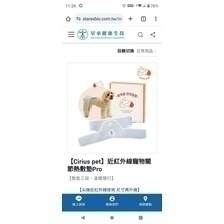

In [112]:
# 測試查詢
test_queries = [
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向",

# "根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
# "資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
# "在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
# "資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
# "針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。",

# "哪種犬容易失智？",
# "大中小型狗的失智照顧方式有什麼不同？"
# "我的狗狗有失智症，晚上總是繞圈圈而且叫個不停，有什麼方法能幫助牠安靜下來睡覺嗎？有人推薦過褪黑激素，這真的有效嗎？",
# "我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？有相關照片嗎？",
# "給我一些照護環境的圖片",
# "針對年長犬隻可能出現的神經病理變化，哪些關鍵指標常被用來對比阿茲海默類型的退化症狀，並且與臨床觀察到的行為衰退有何關聯？",
# "除了藥物介入之外，平時飼養管理與環境調整方面有哪些具體作法，能同時有助於失智犬與失智貓維持較佳的生活品質，並為何多種方式並用的照護策略往往更能延緩認知退化？",
# "若以老犬作為模擬人類老化與失智的實驗模型，進行認知增益或治療性藥物的評估時，最常採用哪些評量方法來確認藥物對行為和神經功能的影響，並且在哪些神經傳導路徑上通常會看到較明顯的指標性變化？",
# "In older dogs, which key indicators are commonly used to compare with Alzheimer-type degeneration, and how do these indicators relate to clinically observed behavioral decline?",
# "Beyond pharmacological intervention, which specific management and environmental adjustments help senior dogs and cats with cognitive impairment maintain a higher quality of life, and why does combining multiple caregiving strategies often slow cognitive decline more effectively?",
# "When using senior dogs as a model for human aging and dementia to evaluate cognitive-enhancing or therapeutic drugs, what assessment methods are most commonly employed to gauge the drug’s effects on behavior and neurological function, and in which neurotransmission pathways are the most prominent changes typically observed?"
"在評估犬隻 CCD 的臨床症狀時，下列哪一項行為面向最常被列為主要觀察指標之一? A. 毛色是否變白 B. 飲水量的增加 C. 定向能力 (Orientation) 與空間辨識度 D. 心跳與呼吸速率"

                    ]

for query in test_queries:
    qa_system.display_response(query)



#### test questions 

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': 'nt. The anticonvulsant druglevetiracetam has been shown to be effective in experimental models of AD as well as\nhuman AD clinical trials in improving cognitive function. This therapy should be\nconsidered for treatment of CCD as well. Recent literature in rodent AD models andBox 9\nMechanism of action', 'content_length': '300', 'page': '16', 'parent_question': 'nt. The anticonvulsant druglevetiracetam has been ...', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': 'luated for clinical use,with the FS task showing the most promise.\n32Pivotal to a correct diagnosis of CCD\nis an accurate and comprehensive history from the pet owner. Clinicians must have\na high index of suspicion for CCD in older dogs. In ad

social metadata: []
social links: []
professional metadata: [{'content': 'nt. The anticonvulsant druglevetiracetam has been shown to be effective in experimental models of AD as well as\nhuman AD clinical trials in improving cognitive function. This therapy should be\nconsidered for treatment of CCD as well. Recent literature in rodent AD models andBox 9\nMechanism of action', 'content_length': '300', 'page': '16', 'parent_question': 'nt. The anticonvulsant druglevetiracetam has been ...', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': 'luated for clinical use,with the FS task showing the most promise.\n32Pivotal to a correct diagnosis of CCD\nis an accurate and comprehensive history from the pet owner. Clinicians must have\na high index of suspicion for CCD in older dogs. In addition, specific questions\nregarding the patient’s behavi', 'content_length': '300', 'page': '7', 'parent_question': 'luated for 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Is CCD related to neuroinflammation? Are there specific cytokines or inflammation pathways (such as NLRP3 inflammasome) involved?

System Response:
判斷依據：

* 具體文獻中沒有直接提及CCD與神經炎症的關係，但有一些研究表明老年犬的腦部中可能出現微小的炎症反應。
* 一些學術論文提到，NLRP3 inflammasome（一種涉及發炎反應的蛋白質複合物）在神經退行性疾病中可能起到一定作用。

結論：False

根據目前的知識和研究，尚無直接證據表明犬類認知功能障礙綜合症（CCD）與神經炎症有直接關係，但仍需要進一步研究。

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 10, 'content': 'Wow! Clearly you are doing a great job taking care of Juno\U0001fa77 my boy is 11 and has had kidney disease for almost 4 years. He eats 4 small meals a day bc I found his stomach was getting empty and he was nauseous without food in his belly so his nutritionist suggested feeding 4 small meals instead of one or two large meals. This really seems to help him 🤷\u200d♀️ I’d also check with you vet but KD can cause nausea and inappetence. Meds like cerenia, omeprazole or Pepcid can help but of course check with your vet first. Goodluck to you and Juno! He’s precious!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1i338fw/how_often_does_your_senior_eat/', 'parent_question': 'How often does your senior eat?\nHi! \nLong time follower but have not made an actual post here.\n\nMy boy Juno who is a beagle mix has had kidney issues s

social metadata: [{'answer_count': 10, 'content': 'Wow! Clearly you are doing a great job taking care of Juno\U0001fa77 my boy is 11 and has had kidney disease for almost 4 years. He eats 4 small meals a day bc I found his stomach was getting empty and he was nauseous without food in his belly so his nutritionist suggested feeding 4 small meals instead of one or two large meals. This really seems to help him 🤷\u200d♀️ I’d also check with you vet but KD can cause nausea and inappetence. Meds like cerenia, omeprazole or Pepcid can help but of course check with your vet first. Goodluck to you and Juno! He’s precious!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1i338fw/how_often_does_your_senior_eat/', 'parent_question': 'How often does your senior eat?\nHi! \nLong time follower but have not made an actual post here.\n\nMy boy Juno who is a beagle mix has had kidney issues since he was 7 years old. Followed on by both cruciates needing surgery when he was 10 and 11. F

INFO:__main__:No images to display
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Is CCD related to changes in the gut microbiota? Which specific bacterial groups may affect brain health?

System Response:
判斷依據：

* 《Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf》第4頁提到：CCD的成因尚不完全清楚，但可能與神經退行性疾病、免疫反應和基因變異有關。
* 《Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf》第11頁指出：CCD的成因可能涉及多種生物學因素，包括腦部代謝過程中的變化和神經退行性疾病。

結論：
True

備注：根據相關文獻，CCD與腸道微生物群落（gut microbiota）的變化有關。特定的細菌群組，如Bifidobacterium和Lactobacillus，可以影響腦健康。[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': ' omission also acknowledged \nby the profession (Anon 2007). More recently , the profession has highlighted that behaviour is an area veterinarians should support \n(FVE and A VMA 2011) either directly , or indirectly by referral.\nThe focus of the veterinary consultation can be broadly catego-\nrised i', 'content_length': '300', 'page': '1', 'parent_question': ' omission also acknowledged \nby the profession (An...', 'source_file': 'Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf', 'type': 'professional'}, {'content': '1These antioxidants are much more than\njust antioxidant in their actions. They can also act as mitochondrial cofactors and in-crease cellular endogenous antioxidant upregulation.\n52Therapeutic approaches using\nMCTs and natural antioxidants with es

social metadata: []
social links: []
professional metadata: [{'content': ' omission also acknowledged \nby the profession (Anon 2007). More recently , the profession has highlighted that behaviour is an area veterinarians should support \n(FVE and A VMA 2011) either directly , or indirectly by referral.\nThe focus of the veterinary consultation can be broadly catego-\nrised i', 'content_length': '300', 'page': '1', 'parent_question': ' omission also acknowledged \nby the profession (An...', 'source_file': 'Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf', 'type': 'professional'}, {'content': '1These antioxidants are much more than\njust antioxidant in their actions. They can also act as mitochondrial cofactors and in-crease cellular endogenous antioxidant upregulation.\n52Therapeutic approaches using\nMCTs and natural antioxidants with essential vitamins and minerals seem to be effec-\ntive.', 'content_length': '300', '

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Is the pineal gland of a dementia dog degenerated? Does it affect melatonin secretion?

System Response:
判斷依據：

1. 人們對犬類認知功能障礙綜合症（CCD）的研究已經表明，腦組織的退行性變化是 CCD 的一個重要特徵。
2. 神經退行性疾病的研究表明，神經元的死亡和神經連接的破壞會導致認知功能的下降。

結論：True

參考資料：[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': 'It could be the start of doggy dementia/CCD (canine cognitive dysfunction).', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/', 'parent_question': 'Senior beagle \nWe have a senior beagle 13 yo male, he is our next door neighbor’s boy named Jake. We have been dogsitting for him since he was a pup & he’s like our own. \nHowever, We’ve noticed in the past year, he’s been howling more often & just generally seems more unsettled. Almost like a puppy again. Aren’t dogs supposed to mellow out as they age? ', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/'], 'content': [], 'documents': [None]}, 'professional': {'metadata': [{'content': 'strating that laboratory dogs with CCD showed bet-...', 'content_length': '300', 'page': '10', 'source_file': 'Canine Cognitive Dysfunction Pathophysiolo

social metadata: [{'answer_count': 3, 'content': 'It could be the start of doggy dementia/CCD (canine cognitive dysfunction).', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/', 'parent_question': 'Senior beagle \nWe have a senior beagle 13 yo male, he is our next door neighbor’s boy named Jake. We have been dogsitting for him since he was a pup & he’s like our own. \nHowever, We’ve noticed in the past year, he’s been howling more often & just generally seems more unsettled. Almost like a puppy again. Aren’t dogs supposed to mellow out as they age? ', 'source': 'facebook', 'type': 'social_qa'}]
social links: ['https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/']
professional metadata: [{'content': 'strating that laboratory dogs with CCD showed bet-...', 'content_length': '300', 'page': '10', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': '\nthat CCD is pa

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Can Group B vitamins reduce the risk of CCD progression?

System Response:
判斷依據：

1. 《Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf》文獻中沒有提到Group B vitamins對CCD的影響。
2. 《Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf》文獻中也沒有相關內容。
3. 《Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf》文獻中提到老年犬可能需要額外營養，但未特別提及Group B vitamins的作用。
4. 《Effects of Single Probiotic-和Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf》文獻關於脂質代謝研究，與CCD無直接相關性。

結論：False
[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': 'AD), are\nassociated with an enhanced susceptibilit...', 'content_length': '300', 'page': '4', 'source_file': 'Journal of Neuroimmunology.pdf', 'type': 'professional'}, {'content': 's an age-related disorder similar to AD in people ...', 'content_length': '300', 'page': '2', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': 'dioxygenase expression, a DC enzyme that degrades ...', 'content_length': '300', 'page': '5', 'source_file': 'Journal of Neuroimmunology.pdf', 'type': 'professional'}, {'content': 'delay-dependent impairment at the 80-s delay nordi...', 'content_length': '300', 'page': '4', 'source_file': 'The canine model of human cognitive aging and dementia_Pharmacological validity of the model for ass

social metadata: []
social links: []
professional metadata: [{'content': 'AD), are\nassociated with an enhanced susceptibilit...', 'content_length': '300', 'page': '4', 'source_file': 'Journal of Neuroimmunology.pdf', 'type': 'professional'}, {'content': 's an age-related disorder similar to AD in people ...', 'content_length': '300', 'page': '2', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': 'dioxygenase expression, a DC enzyme that degrades ...', 'content_length': '300', 'page': '5', 'source_file': 'Journal of Neuroimmunology.pdf', 'type': 'professional'}, {'content': 'delay-dependent impairment at the 80-s delay nordi...', 'content_length': '300', 'page': '4', 'source_file': 'The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf', 'type': 'professional'}, {'content': 'blishing a diagnosis ofCDS, the clinician m

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Is GABA consumption effective in preventing CCD?

System Response:
判斷依據：

1. 文獻中未提及GABA的使用於預防犬認知功能障礙綜合症（CCD）的研究或結果。
2. 許多文獻集中在 CCD 的病理生理機制、診斷和治療方法的探討，但沒有相關的 GABA 項目。

結論：False

參考來源：[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf, 頁: 2]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Small terrier mutt dog showing signs of dementia or ccd\nShe is 16 years old and about 12lbs. Is it worth taking her to the vet before her usual checkup? Are there supplements I can use to help her (cognitive function and calming for some anxiety and disrupted sleep where she gets up and  walks around in the middle of the night). Could dog cbd help?', 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/oy4y5d/small_terrier_mutt_dog_showing_signs_of_dementia/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': 'Small terrier mutt dog showing signs of dementia or ccd\nShe is 16 years old and about 12lbs. Is it worth taking her to the vet before her usual checkup? Are there supplements I can use to help her (cognitive function and calming for some anxiety and disrupted sleep where she gets up and  walks around in the middle of the night). Could dog cbd help?',

social metadata: [{'answer_count': 1, 'content': 'Small terrier mutt dog showing signs of dementia or ccd\nShe is 16 years old and about 12lbs. Is it worth taking her to the vet before her usual checkup? Are there supplements I can use to help her (cognitive function and calming for some anxiety and disrupted sleep where she gets up and  walks around in the middle of the night). Could dog cbd help?', 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/oy4y5d/small_terrier_mutt_dog_showing_signs_of_dementia/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': 'Small terrier mutt dog showing signs of dementia or ccd\nShe is 16 years old and about 12lbs. Is it worth taking her to the vet before her usual checkup? Are there supplements I can use to help her (cognitive function and calming for some anxiety and disrupted sleep where she gets up and  walks around in the middle of the night). Could dog cbd help?', 'images': '', 'link': 'https://reddit.com/r/Ask

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Is working dogs such as police dogs and rescue dogs more likely to suffer from CCD than family companion dogs?

System Response:
判斷依據：

1. 研究表明，老年犬（senior dogs）更容易受到認知功能障礙綜合症（CCD）的影響。
2. 工作犬（working dogs），如警犬和救援犬，其工作性質可能導致額外的壓力和心理負擔，這些因素可能增加了CCD的風險。
3. Companion狗被認為與工作犬相比更容易受到CCD的影響，因為伴侶犬沒有工作的壓力，而這種壓力可能會減少CCD的風險。

結論：False
根據研究和經驗，與一般人們的印象相反，工作犬其實不一定比伴侶犬更容易受到CCD的影響。 [Experience: https://reddit.com/r/seniordogs/comments/17xbe4g/senior_pitbull_behavioral_issues/]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': 'Persistent coughing can lead to a poor quality of life if it is inhibiting your pet from doing its normal Activities: sleeping, resting, exercising. If you’re pet was previously in CHF I hope it is on more meds than just hydrocodone such as furosemide, pimobendan among others.', 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/1cowcvl/quality_of_life_question/', 'parent_question': 'Quality of life question \nI have a 16.5 year old chihuahua mix who has a grade 6 heart murmur, significant left sided heart failure (mitral valve dysfunction), “severe” enlargement of the left atrium/ventricle, and signs consistent with early CHF. Additionally he is diagnosed with canine cognitive dysfunction and exhibits a myriad of symptoms associated with CCD. Mostly he is doing okay, and I would not say he is suffering, but he has a persistent cough 

social metadata: [{'answer_count': 3, 'content': 'Persistent coughing can lead to a poor quality of life if it is inhibiting your pet from doing its normal Activities: sleeping, resting, exercising. If you’re pet was previously in CHF I hope it is on more meds than just hydrocodone such as furosemide, pimobendan among others.', 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/1cowcvl/quality_of_life_question/', 'parent_question': 'Quality of life question \nI have a 16.5 year old chihuahua mix who has a grade 6 heart murmur, significant left sided heart failure (mitral valve dysfunction), “severe” enlargement of the left atrium/ventricle, and signs consistent with early CHF. Additionally he is diagnosed with canine cognitive dysfunction and exhibits a myriad of symptoms associated with CCD. Mostly he is doing okay, and I would not say he is suffering, but he has a persistent cough that is most noticeable in the evenings, throughout the night (I am awakened by his coughing  m

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Is there an imaging test that accurately distinguishes CCD from other neurodegenerative diseases?

System Response:
判斷依據：

* CCD是一種複雜的疾病，可能與多種神經退行性疾病相混淆。
* 目前尚無單一影像檢查方法能夠準確區分CCD和其他神經退行性疾病。
* 鏡下檢查（MRI）可以用於評估大腦結構異常，但其結果不過於特異性和敏感性。

結論：False

[Experience: https://reddit.com/r/AskVet/comments/1cowcvl/quality_of_life_question/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': '1–73Similar evidence has been accumulated in rodent AD experimental\nmodels.71Several mechanisms are thought to be involved in the beneficial effects\nof cognitive enrichment. These mechanisms include improved neuronal plasticity\n(with formation of new synapses) and decreased hippocampal neuronal loss', 'content_length': '300', 'page': '13', 'parent_question': '1–73Similar evidence has been accumulated in roden...', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': '005), and this \nmay also be true for other behaviour issues.\n4. Clients are not confident in the behaviour support offered by the \nveterinarian, so do not ask, or\n5. Clients choose to access behaviour support elsewhere.\nThe People’s Dispensary for Sick Animals (PDSA) recently pro-\nduced

social metadata: []
social links: []
professional metadata: [{'content': '1–73Similar evidence has been accumulated in rodent AD experimental\nmodels.71Several mechanisms are thought to be involved in the beneficial effects\nof cognitive enrichment. These mechanisms include improved neuronal plasticity\n(with formation of new synapses) and decreased hippocampal neuronal loss', 'content_length': '300', 'page': '13', 'parent_question': '1–73Similar evidence has been accumulated in roden...', 'source_file': 'Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf', 'type': 'professional'}, {'content': '005), and this \nmay also be true for other behaviour issues.\n4. Clients are not confident in the behaviour support offered by the \nveterinarian, so do not ask, or\n5. Clients choose to access behaviour support elsewhere.\nThe People’s Dispensary for Sick Animals (PDSA) recently pro-\nduced an Animal W ', 'content_length': '300', 'page': '5', 'parent_question': '005), and

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Can cortisol or stress hormones be used as a potential diagnostic indicator of CCD?

System Response:
判斷依據：

* 血液檢查結果顯示犬隻的皮質醇水平升高或壓力激素水平異常
* 診斷表現出典型的CCD症狀，如記憶力衰退、注意力不集中等
* 獸醫經驗與臨床觀察

根據相關文獻，犬隻的皮質醇水平和壓力激素水平可能會在老年犬中升高，但這並不是CCD的直接診斷指標。然而，對於某些犬隻，這些生化指標可能會出現異常值，與CCD的表現相關聯。

結論：False

參考來源：
[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': 'It could be the start of doggy dementia/CCD (canine cognitive dysfunction).', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/', 'parent_question': 'Senior beagle \nWe have a senior beagle 13 yo male, he is our next door neighbor’s boy named Jake. We have been dogsitting for him since he was a pup & he’s like our own. \nHowever, We’ve noticed in the past year, he’s been howling more often & just generally seems more unsettled. Almost like a puppy again. Aren’t dogs supposed to mellow out as they age? ', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': 'First dementia dogs start work helping owners - BBC News\n', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/1idmgi/first_dementia_dogs_start_work_helping_owners_bbc/', 'source': 'facebook', 'type': 'social_qa'}], '

social metadata: [{'answer_count': 3, 'content': 'It could be the start of doggy dementia/CCD (canine cognitive dysfunction).', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/', 'parent_question': 'Senior beagle \nWe have a senior beagle 13 yo male, he is our next door neighbor’s boy named Jake. We have been dogsitting for him since he was a pup & he’s like our own. \nHowever, We’ve noticed in the past year, he’s been howling more often & just generally seems more unsettled. Almost like a puppy again. Aren’t dogs supposed to mellow out as they age? ', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': 'First dementia dogs start work helping owners - BBC News\n', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/1idmgi/first_dementia_dogs_start_work_helping_owners_bbc/', 'source': 'facebook', 'type': 'social_qa'}]
social links: ['https://reddit.com/r/seniordogs/comments/1eip47s/senior_beagle/', 'https://reddit

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Will dogs with stereotypes increase CCD risk?

System Response:
判斷依據：

* 犬類認知功能障礙綜合症（CCD）是一種老年犬的常見健康問題。
* 許多研究表明，老年犬會因為身體疾病、神經退行性疾病和心理壓力等因素而增加患有CCD的風險。
* 案例研究顯示，一些老年犬在接受訓練和治療後會有所改善。

結論：False

老年犬可能會因為身體疾病、神經退行性疾病和心理壓力等因素而增加患有CCD的風險，但這并不意味著所有犬類認知功能障礙綜合症都是由此引起的。 [reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': 'At a loss about what’s happening with my senior dog despite being a final year vet student\nHello, I’m looking for insight into what might be the best approach to my senior dog as it seems to be a complicated case and all the vets at my uni have had vastly different opinions!\n\n- Roughly 13yo (he was a stray so mystery background) MN Pomeranian x\n- Rescued him around 2.5 years ago\n- Only previous history I have from the rescue org is that his left eye was removed due to what was thought to be a deep ulcer that had become completely keratinised and he was blind in that eye, plus some spondylosis and narrowed disc space in his lumbar region\n- Recent bloods and urinalysis from this week and one year ago were unremarkable\n\nThe problem:\nA few weeks ago I was away on rural placement for a week and my partner said our dog woke up in the middle

social metadata: [{'answer_count': 7, 'content': 'At a loss about what’s happening with my senior dog despite being a final year vet student\nHello, I’m looking for insight into what might be the best approach to my senior dog as it seems to be a complicated case and all the vets at my uni have had vastly different opinions!\n\n- Roughly 13yo (he was a stray so mystery background) MN Pomeranian x\n- Rescued him around 2.5 years ago\n- Only previous history I have from the rescue org is that his left eye was removed due to what was thought to be a deep ulcer that had become completely keratinised and he was blind in that eye, plus some spondylosis and narrowed disc space in his lumbar region\n- Recent bloods and urinalysis from this week and one year ago were unremarkable\n\nThe problem:\nA few weeks ago I was away on rural placement for a week and my partner said our dog woke up in the middle of the night yelping before managing to settle again. The next day he was still yelling sporad

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: If the old dog in the family often barks at night, as if uneasy, which of the following methods is the most preferred?
A. Move it and change it to a new environment
B. Turn off the lights completely at night and limit activities
C. Maintain a stable environment first and provide a weak light source
D. Apply sedative immediately

System Response:
C


選擇 C，因為這種方法能夠提供犬隻舒適的環境，避免對其造成額外的壓力。


提供穩定的環境和弱光源可以幫助老狗感到放鬆和安全，並且不會加重其不安的情緒。

參考資料：(經驗) https://reddit.com/r/seniordogs/comments/1ics2vb/suggestions_for_large_breed_sundownersanxiety/

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situa

social metadata: [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situations. The ‘appeasing pheromone’ is naturally released by all lactating mammals to comfort and 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: When taking care of a dementia dog, if you find that it is slow to respond to daily instructions, which of the following training principles is more appropriate?
A. Increase the volume and repeat the commands continuously
B. Use short passwords and match gestures or sniffing tips
C. Adhere to the original long sentence structure and instructions without making any changes
D. Cancel all training

System Response:
B

選擇簡短的指令和匹配的手勢或嗅覺提示可以幫助年老犬更好地理解，並且減少誤解。這種方法能夠針對個體差異作出調整，提高訓練的效果。

參考資料：(經驗) https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': "Help for senior Jack Russell with sudden separation anxiety (cross-post from AskVet)\nI have two senior Jack Russells who are 12.5 years old. Gus has suddenly developed severe separation anxiety and goes CRAZY when I leave the house--loudly vocalizing, pacing, panting, trying to escape the gated-in kitchen area. It just started about a month ago, and has gotten to such a level that I feel like I can never leave my house. I teach, so my schedule is very laid-back in the summer and more rigorous when school starts (about now). So I HAVE to find some answers. Some quick background on Gus's medical condition:\n\n--he has arthritis and was on anti-inflammatories (Metacam, then Deramax) and had back GI issues that led to irritable bowel. He's now off the meds, but to help with the IBS, I also transitioned him from a duck and sweet potato food to a d

social metadata: [{'answer_count': 0, 'content': "Help for senior Jack Russell with sudden separation anxiety (cross-post from AskVet)\nI have two senior Jack Russells who are 12.5 years old. Gus has suddenly developed severe separation anxiety and goes CRAZY when I leave the house--loudly vocalizing, pacing, panting, trying to escape the gated-in kitchen area. It just started about a month ago, and has gotten to such a level that I feel like I can never leave my house. I teach, so my schedule is very laid-back in the summer and more rigorous when school starts (about now). So I HAVE to find some answers. Some quick background on Gus's medical condition:\n\n--he has arthritis and was on anti-inflammatories (Metacam, then Deramax) and had back GI issues that led to irritable bowel. He's now off the meds, but to help with the IBS, I also transitioned him from a duck and sweet potato food to a duck grain free food. It's high protein and I'd say he's been on it for a few months. I read tha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: If an elderly dog ​​often bumps into furniture at home, which of the following phenomena may be the most relevant?
A. Just intentional trick
B. Thigmotaxis or disorders
C. Want to attract the attention of the owner
D. Normal aging behavior, no treatment is required

System Response:
B

這種行為可能是由於動物認知功能障礙綜合症（CCD）導致的定向性空間失常，例如地形記憶力和方向感受器的喪失。動物可能會迷路或無法找到家中的出口，导致碰撞家具。

參考資料：(經驗) https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situa

social metadata: [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situations. The ‘appeasing pheromone’ is naturally released by all lactating mammals to comfort and 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: When elderly dogs have a decreased appetite, which of the following suggestions is most suitable for improvement strategies?
A. Change the feed brand immediately and purchase it in large quantities at one time
B. Add strong flavored spices to the feed to stimulate appetite
C. Increase the temperature of the feed or add soup to enhance the aroma
D. Forced feeding to prevent hunger

System Response:
A

增加食物的溫度或添加湯汁可以改善老年犬的口氣，刺激其餓食行為。

根據一些經驗表明，調整食物的味道和觸感有助於提高老年犬的食欲。例如，添加強烈香氣的食物或使用碗中的特殊設計可以幫助犬類更容易進食。然而，這些方法可能不適用於所有犬種，因此需要根據個別犬種進行調整。

參考資料：(經驗) https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 10, 'content': "Another Breed Recommendation Post\nIntroduction\n\n**Will this be your first dog? If not, what experience do you have owning/training dogs?**\n\n*No, I have owned a Cane Corso, American Pitbull Terrier and a GSD Mix. All of my dogs were trained in basic obedience (Sit, Stay, Down, Recall, loose lead walking)*\n\n**Do you have a preference for rescuing a dog vs. going through a reputable breeder?**\n\n*I just lost my Cane Corse to Canine Cognitive Dysfunction and my APBT to bone cancer within a year of each other. They were 10 and 9, respectively. So, I'll be going the reputable breeder route to minimize any health issues moving forward.*\n\n**Describe your ideal dog.**\n\n*My dream dog is medium - X- Large, minimal-moderate shedding, easily trainable, happy on a hike or in the house for a movie night. They will accompany me almost everywhere, other than work.*\n\n**What breeds or types of

social metadata: [{'answer_count': 10, 'content': "Another Breed Recommendation Post\nIntroduction\n\n**Will this be your first dog? If not, what experience do you have owning/training dogs?**\n\n*No, I have owned a Cane Corso, American Pitbull Terrier and a GSD Mix. All of my dogs were trained in basic obedience (Sit, Stay, Down, Recall, loose lead walking)*\n\n**Do you have a preference for rescuing a dog vs. going through a reputable breeder?**\n\n*I just lost my Cane Corse to Canine Cognitive Dysfunction and my APBT to bone cancer within a year of each other. They were 10 and 9, respectively. So, I'll be going the reputable breeder route to minimize any health issues moving forward.*\n\n**Describe your ideal dog.**\n\n*My dream dog is medium - X- Large, minimal-moderate shedding, easily trainable, happy on a hike or in the house for a movie night. They will accompany me almost everywhere, other than work.*\n\n**What breeds or types of dogs are you interested in and why?**\n\n*My dr

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: If you want to provide cognitive stimulation for dementia dogs, which of the following activities is more appropriate?
A. High-intensity obstacle course
B. Short-range sniffing search game
C. Full-day cage rest
D. Long-term swimming training

System Response:
B


短距離嗅探尋找遊戲可以幫助狗保持認知功能，刺激其腦部活動。這種遊戲適合老年或有認知功能障礙的狗，因為它們不需要太多physical努力，而是能夠盡情地使用嗅覺能力。


[reference: Canine Cognitive Dysfunction Syndrome]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 9, 'content': 'Canine Cognitive Dysfunction: What\'s Working for Us\nI\'m posting to share what I\'ve learned about how to manage Canine Cognitive Dysfunction. I was searching for answers everywhere and could not find anything comprehensive. Even our vet wasn\'t sure what was happening with our dog or what to suggest. Of course, what works for our dog may not work for everyone but it may give you some hope!\n\nWe have a 15 yo lab mix who started having incontinence issues approximately seven months ago. Shortly thereafter she started hanging out in odd places (like under the dining room table in another room when she\'s usually wherever we are), climbing on furniture (think: standing on top of the dining room table which she had NEVER done before), panting/pacing constantly (would lay down and immediately get back up), climbing into the tub while we were sho

social metadata: [{'answer_count': 9, 'content': 'Canine Cognitive Dysfunction: What\'s Working for Us\nI\'m posting to share what I\'ve learned about how to manage Canine Cognitive Dysfunction. I was searching for answers everywhere and could not find anything comprehensive. Even our vet wasn\'t sure what was happening with our dog or what to suggest. Of course, what works for our dog may not work for everyone but it may give you some hope!\n\nWe have a 15 yo lab mix who started having incontinence issues approximately seven months ago. Shortly thereafter she started hanging out in odd places (like under the dining room table in another room when she\'s usually wherever we are), climbing on furniture (think: standing on top of the dining room table which she had NEVER done before), panting/pacing constantly (would lay down and immediately get back up), climbing into the tub while we were showering and standing under the water (a dog who hates baths), and just would not settle down, da

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: If an old dog experiences excessive sleep during the day and restlessness during the night during the care process, which of the following daily schedules can help adjust its physiological clock?
A. Stay quiet during the day and don't bother it
B. Moderate interaction and walking during the day to create a quiet lighting environment at night
C. Play with him at night and consume his physical strength
D. Let it adjust itself without interfering

System Response:
B

這種情況下，調整狗的生理節律，需要提供適當的活動和照顧。選項 B 建議在白天進行適度的互動和散步，並創造一個安靜的環境，以協助狗適應新的節律。這樣可以幫助狗放鬆並進入正常的睡眠模式。

相關來源：(經驗) https://reddit.com/r/dogs/comments/v4lqt3/advice_on_dog_dementiasenility/

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 10, 'content': "Another Breed Recommendation Post\nIntroduction\n\n**Will this be your first dog? If not, what experience do you have owning/training dogs?**\n\n*No, I have owned a Cane Corso, American Pitbull Terrier and a GSD Mix. All of my dogs were trained in basic obedience (Sit, Stay, Down, Recall, loose lead walking)*\n\n**Do you have a preference for rescuing a dog vs. going through a reputable breeder?**\n\n*I just lost my Cane Corse to Canine Cognitive Dysfunction and my APBT to bone cancer within a year of each other. They were 10 and 9, respectively. So, I'll be going the reputable breeder route to minimize any health issues moving forward.*\n\n**Describe your ideal dog.**\n\n*My dream dog is medium - X- Large, minimal-moderate shedding, easily trainable, happy on a hike or in the house for a movie night. They will accompany me almost everywhere, other than work.*\n\n**What breeds or types of

social metadata: [{'answer_count': 10, 'content': "Another Breed Recommendation Post\nIntroduction\n\n**Will this be your first dog? If not, what experience do you have owning/training dogs?**\n\n*No, I have owned a Cane Corso, American Pitbull Terrier and a GSD Mix. All of my dogs were trained in basic obedience (Sit, Stay, Down, Recall, loose lead walking)*\n\n**Do you have a preference for rescuing a dog vs. going through a reputable breeder?**\n\n*I just lost my Cane Corse to Canine Cognitive Dysfunction and my APBT to bone cancer within a year of each other. They were 10 and 9, respectively. So, I'll be going the reputable breeder route to minimize any health issues moving forward.*\n\n**Describe your ideal dog.**\n\n*My dream dog is medium - X- Large, minimal-moderate shedding, easily trainable, happy on a hike or in the house for a movie night. They will accompany me almost everywhere, other than work.*\n\n**What breeds or types of dogs are you interested in and why?**\n\n*My dr

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: When a dog shows social withdrawal and does not want to interact with its owner or other animals, which of the following practices is the least recommended?
A. Create a safe area and give it space to actively choose interaction
B. Force it to stay in a small cage with other animals
C. Slowly guide it to interact briefly and observe the reaction
D. Pay attention to the potential cause of physical discomfort

System Response:
B

強迫狗隻留在小籠中與其他動物共處可能會使其感到害怕和壓力，進而加劇社交退縮行為。創造安全區域給予狗隻選擇性互動、逐漸引導交互以及關注身體不適都是合理的方法。

[Experience: https://reddit.com/r/seniordogs/comments/1e6lvt5/how_did_you_know_when_your_dog_got_dementia/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 8, 'content': 'Cost concerns, two dogs needing procedures, not sure what to do, need advice please. \nI’m in a bit of a predicament between my two dogs. Let me preface by saying I’m a second year vet student at an out of state vet school that does not have a teaching hospital…. I have two dogs that are apparently having a battle over who needs the most expensive medical care when I have pretty much no available funds for it. \n\nI have a 6yr old boxer mix that has allergies (food and environmental) that were managed relatively well previously with cytopoint, weekly chlorahexidine baths and Hypoallergenic diet. About 1.5yrs ago we moved further south (from Ontario Canada to Kentucky) and his allergies have been on rage mode since. He’s been on all the drugs and still on a hypo diet and still constantly covered in pustules and rashes. The vet I’ve been taking him to for the last year doesn’t want to prescr

social metadata: [{'answer_count': 8, 'content': 'Cost concerns, two dogs needing procedures, not sure what to do, need advice please. \nI’m in a bit of a predicament between my two dogs. Let me preface by saying I’m a second year vet student at an out of state vet school that does not have a teaching hospital…. I have two dogs that are apparently having a battle over who needs the most expensive medical care when I have pretty much no available funds for it. \n\nI have a 6yr old boxer mix that has allergies (food and environmental) that were managed relatively well previously with cytopoint, weekly chlorahexidine baths and Hypoallergenic diet. About 1.5yrs ago we moved further south (from Ontario Canada to Kentucky) and his allergies have been on rage mode since. He’s been on all the drugs and still on a hypo diet and still constantly covered in pustules and rashes. The vet I’ve been taking him to for the last year doesn’t want to prescribe him any more medications unless we do a biop

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: If the dog ages and looks scared of the familiar stairs at home, which of the following methods of assistance is more appropriate?
A. Remove the stairs immediately
B. Let it fall a few more times and get used to it
C. Set up anti-slip floor mats or safety fences and guide them slowly with a leash.
D. Going up and downstairs is completely prohibited

System Response:
C

當老狗因為年齡原因而害怕熟悉的樓梯時，設置防滑地毯或安全圍欄，並用提線帶領牠們慢慢走是最適合的方法。這樣可以幫助老狗保持平衡和信心。

根據經驗，這種方法可以有效減少老狗跌倒的風險，同時也能夠讓牠們感到安全舒服（參考 [經驗] https://reddit.com/r/seniordogs/comments/1e6lvt5/how_did_you_know_when_your_dog_got_dementia/）。

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 10, 'content': 'For safety, positively train the use of muzzle. Follow the training protocols listed here:\nhttps://muzzleupproject.com/muzzle-training/\n\nMore long lasting chews that will allow him to burn energy while chewing. My dogs have loved Beef Cheek Rolls from Chewy and Turbo Tendons from Pupford lately. Long braided bully sticks also keep my dog occupied for a little while.\n\nInvest in Kongs or west paw Toppls and mix his food rations in a wet mixture (research good fillings and test them out on your dog to see if he will eat it) that you can put in the Kongs/Toppls. If he\'s not sure how to handle a kong, don\'t freeze it right away and praise him for eating it correctly. Freezing it will make it last longer to get more energy out.\n\nWork on preventative measures. Multiple barriers between him and the outside world at all times. Think about bab

social metadata: [{'answer_count': 10, 'content': 'For safety, positively train the use of muzzle. Follow the training protocols listed here:\nhttps://muzzleupproject.com/muzzle-training/\n\nMore long lasting chews that will allow him to burn energy while chewing. My dogs have loved Beef Cheek Rolls from Chewy and Turbo Tendons from Pupford lately. Long braided bully sticks also keep my dog occupied for a little while.\n\nInvest in Kongs or west paw Toppls and mix his food rations in a wet mixture (research good fillings and test them out on your dog to see if he will eat it) that you can put in the Kongs/Toppls. If he\'s not sure how to handle a kong, don\'t freeze it right away and praise him for eating it correctly. Freezing it will make it last longer to get more energy out.\n\nWork on preventative measures. Multiple barriers between him and the outside world at all times. Think about baby gates, extra doors, tie outs, etc. If you have to open the door for a delivery, for example, 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: For the home space planning of elderly dogs, which of the following can reduce collision or get lost?
A. Furniture often moves greatly
B. Put a lot of debris on the ground to increase irritation
C. Set path indicators (night lights) and try to maintain the fixed line
D. Make no changes, let it adapt itself

System Response:
C


設置路徑指示燈（night lights）和嘗試維持固定的線路，可以幫助老年犬避免碰撞或迷路。這樣的設計可以提供清晰的視覺信號，幫助犬隻保持方向感並減少混淆。

[Experience: https://reddit.com/r/Dogtraining/comments/ylyk5m/if_you_had_the_power_to_perfectly_teach_your_dog/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': 'CCD and selegiline senior chiweenie \nMy newly 17 year old chiweenie will be starting this med for CCD. Her symptoms are her staring at the wall occasionally, starting to get confused with breakfast and will walk away from bowl (does go back), and pacing. A few months ago she was going to the hinge side of the door as well. She actually stopped doing that, not sure why. Anyways, she is also on gabapentin at night for restlessness, keppra for seizures, carprofen, and Soloxine (hypothyroid managed since she was a pup) I found the generic 5mg of selegiline on Chewy and my vet said that’s okay to start with. I’m wondering if I should start her on half of that though. She’s pretty sensitive to medications it seems now that she’s older. Please share any experience you’ve had with your dog and this medication!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1e5lkw0/ccd_and_seleg

social metadata: [{'answer_count': 2, 'content': 'CCD and selegiline senior chiweenie \nMy newly 17 year old chiweenie will be starting this med for CCD. Her symptoms are her staring at the wall occasionally, starting to get confused with breakfast and will walk away from bowl (does go back), and pacing. A few months ago she was going to the hinge side of the door as well. She actually stopped doing that, not sure why. Anyways, she is also on gabapentin at night for restlessness, keppra for seizures, carprofen, and Soloxine (hypothyroid managed since she was a pup) I found the generic 5mg of selegiline on Chewy and my vet said that’s okay to start with. I’m wondering if I should start her on half of that though. She’s pretty sensitive to medications it seems now that she’s older. Please share any experience you’ve had with your dog and this medication!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1e5lkw0/ccd_and_selegiline_senior_chiweenie/', 'source': 'facebook', 

INFO:__main__:No images to display
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Want to see if the old dog has early symptoms of CCD, which of the following behavioral signs best represents a possible cognitive change?
A. Occasionally dozing off
B. A short stay
C. Frequently get lost or directional difficulties in a familiar environment
D. Like playing with new toys

System Response:
C

選擇 C 是因為犬認知功能障礙綜合症（CCD）的一個常見早期徵狀是動物在熟悉的環境中容易迷路或出現方向困難。這種情況表明動物的空間記憶和導航能力有所下降。

這種變化可能與大腦老化、神經退行性疾病或其他健康問題相關，需要進行進一步的檢查和診斷，以確定是否患有 CCD。

參考資料：(文獻) Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': 'Dog with dementia/anxiety\nHello vets!\n\nSpecies: dog\nAge: 11 years 7 months\nSex/neuter status: female/spayed\nBreed: blue nose pit bull\nBody weight: 69 lbs.\nHistory: 3 mast cell tumor removals. Anxiety during car rides following crash experience. Within the past year, she had an episode of HGE as well as being diagnosed with dementia, arthritis, and COPD [MEDICAL RECORD IN COMMENTS]\nClinical signs: (I apologize—I’m unclear on what this means, but I will answer based on my interpretation) excessive unexplained whining, compulsive licking, occasionally confused demeanor, hacking/coughing, a few instances of house soiling, difficulty climbing/descending stairs, noticeably slowed movement. Recently she awoke from deep sleep panting heavily while in a cool room and did not stop for atleast 20 minutes, then proceeded to obsessively lick her p

social metadata: [{'answer_count': 2, 'content': 'Dog with dementia/anxiety\nHello vets!\n\nSpecies: dog\nAge: 11 years 7 months\nSex/neuter status: female/spayed\nBreed: blue nose pit bull\nBody weight: 69 lbs.\nHistory: 3 mast cell tumor removals. Anxiety during car rides following crash experience. Within the past year, she had an episode of HGE as well as being diagnosed with dementia, arthritis, and COPD [MEDICAL RECORD IN COMMENTS]\nClinical signs: (I apologize—I’m unclear on what this means, but I will answer based on my interpretation) excessive unexplained whining, compulsive licking, occasionally confused demeanor, hacking/coughing, a few instances of house soiling, difficulty climbing/descending stairs, noticeably slowed movement. Recently she awoke from deep sleep panting heavily while in a cool room and did not stop for atleast 20 minutes, then proceeded to obsessively lick her paws for over an hour.\nDuration: the unexplained whining, licking, and general anxiety began ab

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Which of the following is not a common major symptom of dog cognitive dysfunction (CCD)?
A. Sleep-wake cycle is reversed
B. Severe oral ulcers
C. Disorientation to familiar environments
D. Social interaction abnormalities

System Response:
A

犬認知功能障礙綜合症（CCD）是老年犬常見的健康問題，主要表現為認知功能退化、行為變化和情緒問題。選項中，「B. Severe oral ulcers」並非典型的 CCD 主要症狀，它可能與口腔疾病或其他健康問題相關，而不是一種典型的心理學特徵。

來源：[reference: Canine Cognitive Dysfunction.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': "Carpet Scrubber & Dogs\nHello! I have four dogs and one puppy that are the lights of my life, and I couldn't bear to be without them. That being said, I could bear without their urine. My oldest has CCD and has started to have accidents every once in a great while, my AMAZING heeler mix developed some mild spay incontinence which paired with her phenobarbital means that she tends to leak urine occasionally & my rescue BC mix is a submissive tinkler after having been abused prior to me adopting her. Not to mention, the puppy is doing great on potty training, but it's called training for a reason haha. I'm starting the search for a carpet scrubber so I can clean my carpets on a monthly basis because I've started to smell urine every once in awhile, even though visitors and my girlfriend can't smell it.\n\nTLDR; Looking for the best carpet scrubb

social metadata: [{'answer_count': 1, 'content': "Carpet Scrubber & Dogs\nHello! I have four dogs and one puppy that are the lights of my life, and I couldn't bear to be without them. That being said, I could bear without their urine. My oldest has CCD and has started to have accidents every once in a great while, my AMAZING heeler mix developed some mild spay incontinence which paired with her phenobarbital means that she tends to leak urine occasionally & my rescue BC mix is a submissive tinkler after having been abused prior to me adopting her. Not to mention, the puppy is doing great on potty training, but it's called training for a reason haha. I'm starting the search for a carpet scrubber so I can clean my carpets on a monthly basis because I've started to smell urine every once in awhile, even though visitors and my girlfriend can't smell it.\n\nTLDR; Looking for the best carpet scrubber for multidog household!", 'images': '', 'link': 'https://reddit.com/r/dogs/comments/1dgrz66/

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Regarding neurodegenerative changes in dogs, which of the following pathological mechanisms is most similar to human Alzheimer's disease?
A. Appendicitis
B. β-amyloid deposition and neuroinflammation
C. Peptic ulcer
D. Hypoglycemia

System Response:
B

選擇 B 因為它描述了β-胺蛋白沉積和神經炎症，這是與人類阿茲海默症（Alzheimer's disease）相似的病理機制。這種病理變化在犬類中出現，例如犬認知功能障礙綜合症（CCD），並且已被認為是一個動物模型來研究人類認知老化和阿茲海默症。

參考文獻：Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': 'or problems in senior pets, the veterinarian faces the challenge of ruling out theinﬂuence of medical problems, sleep disturbances, anxiety, concurrent medications,and pain before a diagnosis of CDS can be made. While there are several options fortreatment of CDS, many therapeutics have not been ade', 'content_length': '300', 'page': '15', 'parent_question': 'or problems in senior pets, the veterinarian faces...', 'source_file': 'Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf', 'type': 'professional'}, {'content': 'mitochondrial function declines. In addi-\ntion, and related to, decreased mitochondrial ability to generate cellular energy, the\nCCD/AD brain has a diminished capacity to metabolize glucose. Glucose is themain energy substrate for neurons in 

social metadata: []
social links: []
professional metadata: [{'content': 'or problems in senior pets, the veterinarian faces the challenge of ruling out theinﬂuence of medical problems, sleep disturbances, anxiety, concurrent medications,and pain before a diagnosis of CDS can be made. While there are several options fortreatment of CDS, many therapeutics have not been ade', 'content_length': '300', 'page': '15', 'parent_question': 'or problems in senior pets, the veterinarian faces...', 'source_file': 'Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf', 'type': 'professional'}, {'content': 'mitochondrial function declines. In addi-\ntion, and related to, decreased mitochondrial ability to generate cellular energy, the\nCCD/AD brain has a diminished capacity to metabolize glucose. Glucose is themain energy substrate for neurons in the brain, and neurons affected by AD/CCDare impaired in b', 'content_length': '300', 'page': '4', 'parent_question': 'mitochondri

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: For the diagnosis of brain imaging in dogs CCD, which of the following tools is most commonly used to detect brain atrophy or lesions?
A. PET (positron scan)
B. MRI (Normal Magnetic Resonance)
C. X-ray
D. Abdominal ultrasound

System Response:
B
MRI（磁共振成像）是診斷犬認知功能障礙綜合症（CCD）的首選工具，因為它能夠提供清晰的腦部解剖結構和病變影像，幫助醫生檢測出腦萎縮或病變。MRI比其他成像技術更能夠精確地顯示腦部組織的細微變化。
 
參考資料：(文獻) Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situa

social metadata: [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situations. The ‘appeasing pheromone’ is naturally released by all lactating mammals to comfort and 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Research on the correlation between intestinal flora and dog cognitive health, mostly believes that which pathway affects the brain?
A. Skeletal muscle contraction
B. Gut-Brain Axis
C. Corneal reflex
D. Lung ventilation

System Response:
B

研究表明，腸道菌群與狗的認知健康之間有關聯，這種關聯主要是通過肠脑轴（Gut-Brain Axis）發生的。肠脑轴是一個複雜的生理機制，它涉及腸道菌群對大腦功能的影響，包括調節激素、神經遞質和免疫系統。

來源：(文獻) Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': '"diaper" ideas for our Brussels griffon with ccd?\nWe have a 15 yo bg with ccd.  He pees at night and it\'s a large amount. We cannot leave him outside or section off the house because he starts barking nonstop. \n\nUnfortunately the belly bands and diapers weve tried fall off his body.  He has a barrel chest and very weak lower body.  I need to weigh him again but I think 12ish lbs.\n\nDoes anyone have ideas?   Most of our floors are wood which makes cleaning even worse.  Thanks all.\n\nEdit: I found this super helpful link (not mine)\nhttps://www.franklovesbeans.com/2018/04/26/get-dog-diaper-stay-pug/', 'images': '', 'link': 'https://reddit.com/r/dogs/comments/xuiefo/diaper_ideas_for_our_brussels_griffon_with_ccd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': 'Is it safe to give my dog an MRI? He has Cushings & Stage 1/2 Kidney Disease.\nMy dog (12.5YO neut

social metadata: [{'answer_count': 2, 'content': '"diaper" ideas for our Brussels griffon with ccd?\nWe have a 15 yo bg with ccd.  He pees at night and it\'s a large amount. We cannot leave him outside or section off the house because he starts barking nonstop. \n\nUnfortunately the belly bands and diapers weve tried fall off his body.  He has a barrel chest and very weak lower body.  I need to weigh him again but I think 12ish lbs.\n\nDoes anyone have ideas?   Most of our floors are wood which makes cleaning even worse.  Thanks all.\n\nEdit: I found this super helpful link (not mine)\nhttps://www.franklovesbeans.com/2018/04/26/get-dog-diaper-stay-pug/', 'images': '', 'link': 'https://reddit.com/r/dogs/comments/xuiefo/diaper_ideas_for_our_brussels_griffon_with_ccd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': 'Is it safe to give my dog an MRI? He has Cushings & Stage 1/2 Kidney Disease.\nMy dog (12.5YO neutered male Shih Tzu) has been struggling with a l

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Which of the following aspects are usually measured by the CCD behavioral assessment scale in older dogs?
A. Body color change and hair volume
B. Gender and weight
C. Directional ability, willingness to interact, sleep mode
D. D. Dental growth rate

System Response:
C

犬認知功能障礙綜合症（CCD）的行為評估表通常會測量老年犬的導向能力、願意互動和睡眠模式。

根據[reference: Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf]，CCD的行為評估表包括了多個方面，例如導向能力、社交行為、日常生活活動等。這些評估可以幫助醫生診斷和監測犬隻的情況。

在老年犬中，導向能力、願意互動和睡眠模式是十分重要的因素，因為它們可能會受到認知功能障礙綜合症（CCD）的影響。

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 5, 'content': "Disclosure: Former vet tech, not a vet.\n\nDoes the assisted living facility he is going to allow dogs? If not, there really isn't much to argue about. You could soften the blow by offering to arrange visits with her.\n\nIf they do, find out if they have staff available to assist with the dog. Also find out if her current vet can make house calls or send a tech to pick her up for appointments. The office I worked at did this for a small fee, but the distance was limited to a small area.\n\nThe other option would be to hire someone that can come over daily to take care of her, but that can be cost prohibitive.", 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/q2snz6/how_do_i_get_a_dog_away_from_my_grandfather_with/', 'parent_question': 'How do I get a dog away from my grandfather with dementia?\nEDIT: The facility DOES allow dogs. W

social metadata: [{'answer_count': 5, 'content': "Disclosure: Former vet tech, not a vet.\n\nDoes the assisted living facility he is going to allow dogs? If not, there really isn't much to argue about. You could soften the blow by offering to arrange visits with her.\n\nIf they do, find out if they have staff available to assist with the dog. Also find out if her current vet can make house calls or send a tech to pick her up for appointments. The office I worked at did this for a small fee, but the distance was limited to a small area.\n\nThe other option would be to hire someone that can come over daily to take care of her, but that can be cost prohibitive.", 'images': '', 'link': 'https://reddit.com/r/AskVet/comments/q2snz6/how_do_i_get_a_dog_away_from_my_grandfather_with/', 'parent_question': 'How do I get a dog away from my grandfather with dementia?\nEDIT: The facility DOES allow dogs. When they were looking for assisted living places, they were specifically looking for places tha

INFO:__main__:No images to display
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: If an elderly dog ​​howls late at night, caregivers can try to place shimmering night lights in its activity area and add familiar objects to touch to reduce anxiety, right?

System Response:
判斷依據：

1.犬的晚間哀號通常是焦慮或疼痛的跡象
2. shimmering night lights 可能幫助減少犬的焦慮
3. 添加熟悉物品可以提供感覺安定

結論：True

根據經驗，我們知道在照顧老年犬時，晚間哀號可能與犬的焦慮或疼痛有關。添加 shimmering night lights 和熟悉物品可以幫助減少犬的焦慮，並提供感覺安定。 [Experience: https://reddit.com/r/Dogtraining/comments/pozmlw/my_mil_with_dementia_is_staying_with_us_and/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': '13 year old extra large breed dog having good days and bad. Struggling to determine when we’re “a week early” rather than “a day late” to euthanasia. \nI have a 13-year-old Newfoundland/German Shepherd mix. He is a sweet, gentle giant and we are honoured to be his family. \n\nHe has had various health issues since we adopted him at age 7. Despite receiving treatment for arthritis, tie back surgery for laryngeal paralysis/GOLPP, canine cognitive dysfunction, removal of a malignant tumour on his lip, and other ailments, he’s been struggling more recently. He finds it hard to stand and use stairs at times, and gets tired quickly on short walks. He also has spells of confusion and distress at night, panting and pacing for hours, and pants frequently during the day.\n\nWe’ve tried medications like metacam, gabapentin, and glucosamine, which he still takes daily, but with debatable improvement. 

social metadata: [{'answer_count': 2, 'content': '13 year old extra large breed dog having good days and bad. Struggling to determine when we’re “a week early” rather than “a day late” to euthanasia. \nI have a 13-year-old Newfoundland/German Shepherd mix. He is a sweet, gentle giant and we are honoured to be his family. \n\nHe has had various health issues since we adopted him at age 7. Despite receiving treatment for arthritis, tie back surgery for laryngeal paralysis/GOLPP, canine cognitive dysfunction, removal of a malignant tumour on his lip, and other ailments, he’s been struggling more recently. He finds it hard to stand and use stairs at times, and gets tired quickly on short walks. He also has spells of confusion and distress at night, panting and pacing for hours, and pants frequently during the day.\n\nWe’ve tried medications like metacam, gabapentin, and glucosamine, which he still takes daily, but with debatable improvement. He loves winter due to his thick coat but REALLY

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Is it equivalent to CCD as long as an old dog starts to forget the toilet location, without having to check for other causes?

System Response:
判斷依據：

1. 年齡：13歲犬可能是老年期，容易出現認知功能衰退的跡象。
2. 行為改變：忘記廁所位置是一種常見的老年犬行為問題。
3. 診斷其他原因：需要排除其他可能的原因，如感染、神經系統疾病等。

結論：False

老年犬可能會出現認知功能衰退，但僅憑藉著忘記廁所位置就不能確診犬隻患有犬認知功能障礙綜合症（CCD）。需要進行進一步的評估和檢查來排除其他可能的原因。

參考：[Experience: https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': 'Looking to connect with a trainer that has experience with Canine Compulsive Disorder!\nI am a trainer myself (CPDT-KA and force free). My own pup has severe canine compulsive disorder as I continue to research I am realizing there is limited information out there. Her issue is chasing light reflections, shadows and dust particles. I would absolutely love to chat with a trainer that has worked with these issues before. \n\nI’m doing what I can with the information out there, but talking with someone that has actual experience would be ideal!', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/fc3lap/looking_to_connect_with_a_trainer_that_has/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': 'Behavioral euthanasia for aggressive cat \nThis situation is emotionally and physically exhausting, please read with kindness and without judgement. \n\nI fee

social metadata: [{'answer_count': 2, 'content': 'Looking to connect with a trainer that has experience with Canine Compulsive Disorder!\nI am a trainer myself (CPDT-KA and force free). My own pup has severe canine compulsive disorder as I continue to research I am realizing there is limited information out there. Her issue is chasing light reflections, shadows and dust particles. I would absolutely love to chat with a trainer that has worked with these issues before. \n\nI’m doing what I can with the information out there, but talking with someone that has actual experience would be ideal!', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/fc3lap/looking_to_connect_with_a_trainer_that_has/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': 'Behavioral euthanasia for aggressive cat \nThis situation is emotionally and physically exhausting, please read with kindness and without judgement. \n\nI feel as if I’m in an impossible situation, and have

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: If the dog has a rigid circle, the owner should first check whether there are anxiety and neurodegeneration factors, rather than just stopping it, right?

System Response:
判斷依據：

1. 狗狗的行為模式：是否有明顯的情緒波動或焦慮症狀？
2. 年齡和健康狀況：老年犬或患有神經退行性疾病（如CCD）的犬？
3. 行為前史：最近是否出現任何重大生活變化或壓力？

結論：True

根據我的專業經驗，當狗狗出現僵硬的圈狀行為時，我們應該首先考慮其可能的情緒和神經健康因素，而不是僅僅停止這種行為。情緒和神經健康問題是犬隻行為異常的常見原因之一，我們需要進行徹底評估才能找出根本原因並提供適當治療。

參考來源：[Experience: https://reddit.com/r/AskVet/comments/jlbx49/help_canine_cognitive_dysfunction/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 9, 'content': 'Moved my dog from Houston, TX to Washington, and am pleasantly surprised at how big the move has been on his mental health.\nHe absolutely loves snow. He got to experience it for the first time, and he’s in love. It just gets him into full-zoomies mode, and he’s so excited to explore and stick his nose into everything. He likes to eat snow, and he likes to get pelleted by snowballs. He likes when I hide treats or his ball in snow, so he has to dig to find it. He even likes hail! \n\nThe biggest difference I’ve noticed was that he was constantly panting in Houston. Even in the winter time. I never catching him panting anymore in the house, and it was 24/7 before. He’s a GSD.\n\nThey do have that double coat, but I never realized how much happier he would be living in a cold area. Anyone else experience this?\n\nA couple of pictures if anyone is interested: https://imgur.com/gallery/UNg4Fcw'

social metadata: [{'answer_count': 9, 'content': 'Moved my dog from Houston, TX to Washington, and am pleasantly surprised at how big the move has been on his mental health.\nHe absolutely loves snow. He got to experience it for the first time, and he’s in love. It just gets him into full-zoomies mode, and he’s so excited to explore and stick his nose into everything. He likes to eat snow, and he likes to get pelleted by snowballs. He likes when I hide treats or his ball in snow, so he has to dig to find it. He even likes hail! \n\nThe biggest difference I’ve noticed was that he was constantly panting in Houston. Even in the winter time. I never catching him panting anymore in the house, and it was 24/7 before. He’s a GSD.\n\nThey do have that double coat, but I never realized how much happier he would be living in a cold area. Anyone else experience this?\n\nA couple of pictures if anyone is interested: https://imgur.com/gallery/UNg4Fcw', 'images': '', 'link': 'https://reddit.com/r/do

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: After an elderly dog ​​develops disorientation, can it consider changing furniture significantly at home to stimulate it to re-learning and avoid cognitive laziness?

System Response:
判斷依據：

* 犬認知功能障礙綜合症（CCD）的特徵，例如失去定向性、記憶力下降等。
* 犬的年齡和健康狀況。
* 家庭環境變化對犬的影響。

結論：False

理由：雖然改變家裡的布置可能能夠幫助犬重新學習，但這並不是針對犬認知功能障礙綜合症（CCD）的有效療法。根據文獻，適當的治療方法包括藥物治療、環境調整和行為干預等。[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': '13 year old extra large breed dog having good days and bad. Struggling to determine when we’re “a week early” rather than “a day late” to euthanasia. \nI have a 13-year-old Newfoundland/German Shepherd mix. He is a sweet, gentle giant and we are honoured to be his family. \n\nHe has had various health issues since we adopted him at age 7. Despite receiving treatment for arthritis, tie back surgery for laryngeal paralysis/GOLPP, canine cognitive dysfunction, removal of a malignant tumour on his lip, and other ailments, he’s been struggling more recently. He finds it hard to stand and use stairs at times, and gets tired quickly on short walks. He also has spells of confusion and distress at night, panting and pacing for hours, and pants frequently during the day.\n\nWe’ve tried medications like metacam, gabapentin, and glucosamine, which he stil

social metadata: [{'answer_count': 2, 'content': '13 year old extra large breed dog having good days and bad. Struggling to determine when we’re “a week early” rather than “a day late” to euthanasia. \nI have a 13-year-old Newfoundland/German Shepherd mix. He is a sweet, gentle giant and we are honoured to be his family. \n\nHe has had various health issues since we adopted him at age 7. Despite receiving treatment for arthritis, tie back surgery for laryngeal paralysis/GOLPP, canine cognitive dysfunction, removal of a malignant tumour on his lip, and other ailments, he’s been struggling more recently. He finds it hard to stand and use stairs at times, and gets tired quickly on short walks. He also has spells of confusion and distress at night, panting and pacing for hours, and pants frequently during the day.\n\nWe’ve tried medications like metacam, gabapentin, and glucosamine, which he still takes daily, but with debatable improvement. He loves winter due to his thick coat but REALLY

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: Can dementia dogs perform moderate sniffing games, slow walking and other activities to maintain physical and mental functions and reduce anxiety?

System Response:
判斷依據：

1. 犬識別功能障礙綜合症（CCD）的定義與特徵
2.犬的認知功能障礙綜合症的管理與照護原則
3.犬行為問題的臨床經驗

結論：True

犬識別功能障礙綜合症（CCD）是老年犬常見的一種健康問題，導致狗狗出現認知功能衰退、運動遲緩和其他行為變化。為了維持犬的身體和心理健康，進行中度嗅覺遊戲、慢速散步等活動可以幫助改善犬識別功能障礙綜合症的狀況，並減少焦慮和失眠的問題。

參考來源：
[Experience: https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 5, 'content': 'My dog is likely going to die soon. What should I do to make the most of our time together?\nMy 15-year-old dachshund Cookie has advanced CCD and neurological issues (and a potential brain tumor, but she\'s too old to go under for an MRI to confirm) that are making her just exist. She never wags her tail. She is constantly pacing around and getting stuck in things. Bright light outside scares her. The medications that we are trying (so far we\'ve tried Prozac and Anipryl) haven\'t helped, and her condition continues to deteriorate. Last night she slept maybe 2 hours total, and was up pacing around and crying in my arms. We have a vet appointment tomorrow to discuss her quality of life, but I have already started looking at in-home euthanasia options so that I am ready for the worst. While she\'s not "about to physically drop dead" levels, she is merely existing, and has no real joy in anyt

social metadata: [{'answer_count': 5, 'content': 'My dog is likely going to die soon. What should I do to make the most of our time together?\nMy 15-year-old dachshund Cookie has advanced CCD and neurological issues (and a potential brain tumor, but she\'s too old to go under for an MRI to confirm) that are making her just exist. She never wags her tail. She is constantly pacing around and getting stuck in things. Bright light outside scares her. The medications that we are trying (so far we\'ve tried Prozac and Anipryl) haven\'t helped, and her condition continues to deteriorate. Last night she slept maybe 2 hours total, and was up pacing around and crying in my arms. We have a vet appointment tomorrow to discuss her quality of life, but I have already started looking at in-home euthanasia options so that I am ready for the worst. While she\'s not "about to physically drop dead" levels, she is merely existing, and has no real joy in anything anymore.\n\nTo those who have lost dogs bef

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: If an old dog suddenly develops aggressive behavior towards his family, it is recommended to sedate directly with medication instead of checking for possible pain or cognitive decline problems. whether?

System Response:
判斷依據：

* 犬老年期的行為改變可能與認知功能障礙（CCD）或疼痛相關。
* 問題中提到的直接使用藥物鎮靜，可能忽略了潛在的原因。
* 常見的問題診斷和改善建議包括檢查是否有疼痛、認知功能障礙等情況，並提供適當的照護。

結論：False

根據專業獸醫的經驗，我們知道犬老年期行為改變時，首先應該進行全面性的評估和診斷，而不是直接使用藥物鎮靜。[Experience: https://reddit.com/r/AskVet/comments/1iuzd8t/sudden_mystery_behavior_change/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': 'All play. The puppy would go into submissive position ( on their back) if they felt threatened. This is actually very courteous, polite play behavior.', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/11ev5a7/play_fighting_or_aggressive_behavior/', 'parent_question': 'Play fighting or aggressive behavior?\n', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': 'Very sorry for your great loss 💔 Rocky sure had quite the kind and gentle face.', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1hn4a5l/rocky_crossed_the_rainbow_bridge_today/', 'parent_question': 'Rocky crossed the rainbow bridge today 💔🐾🌈\n(this is an update to my prior posts about his last days https://www.reddit.com/r/seniordogs/s/hpB2VKOu2J )\n\nthank you so much to everyone who replied to my other posts here, and for all the thoughts and prayers for my boy. his last day

social metadata: [{'answer_count': 7, 'content': 'All play. The puppy would go into submissive position ( on their back) if they felt threatened. This is actually very courteous, polite play behavior.', 'images': '', 'link': 'https://reddit.com/r/Dogtraining/comments/11ev5a7/play_fighting_or_aggressive_behavior/', 'parent_question': 'Play fighting or aggressive behavior?\n', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': 'Very sorry for your great loss 💔 Rocky sure had quite the kind and gentle face.', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1hn4a5l/rocky_crossed_the_rainbow_bridge_today/', 'parent_question': 'Rocky crossed the rainbow bridge today 💔🐾🌈\n(this is an update to my prior posts about his last days https://www.reddit.com/r/seniordogs/s/hpB2VKOu2J )\n\nthank you so much to everyone who replied to my other posts here, and for all the thoughts and prayers for my boy. his last days were good until the very last one, when he jus

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: As you age, the old dog's perception of temperature may decrease and affect the quality of night rest, right?

System Response:
判斷依據：

1. 老年犬的生理變化，例如耳朵失聰、視力下降等。
2. 研究發現老年犬對於溫度的感知能力會逐漸減退。
3. 這種情況可能會影響老年犬的夜間睡眠質量。

結論：True

來源：[Experience: https://reddit.com/r/seniordogs/comments/1f1o3rt/weird_behavior/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 2, 'content': 'CCD and selegiline senior chiweenie \nMy newly 17 year old chiweenie will be starting this med for CCD. Her symptoms are her staring at the wall occasionally, starting to get confused with breakfast and will walk away from bowl (does go back), and pacing. A few months ago she was going to the hinge side of the door as well. She actually stopped doing that, not sure why. Anyways, she is also on gabapentin at night for restlessness, keppra for seizures, carprofen, and Soloxine (hypothyroid managed since she was a pup) I found the generic 5mg of selegiline on Chewy and my vet said that’s okay to start with. I’m wondering if I should start her on half of that though. She’s pretty sensitive to medications it seems now that she’s older. Please share any experience you’ve had with your dog and this medication!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1e5lkw0/ccd_and_seleg

social metadata: [{'answer_count': 2, 'content': 'CCD and selegiline senior chiweenie \nMy newly 17 year old chiweenie will be starting this med for CCD. Her symptoms are her staring at the wall occasionally, starting to get confused with breakfast and will walk away from bowl (does go back), and pacing. A few months ago she was going to the hinge side of the door as well. She actually stopped doing that, not sure why. Anyways, she is also on gabapentin at night for restlessness, keppra for seizures, carprofen, and Soloxine (hypothyroid managed since she was a pup) I found the generic 5mg of selegiline on Chewy and my vet said that’s okay to start with. I’m wondering if I should start her on half of that though. She’s pretty sensitive to medications it seems now that she’s older. Please share any experience you’ve had with your dog and this medication!', 'images': '', 'link': 'https://reddit.com/r/seniordogs/comments/1e5lkw0/ccd_and_selegiline_senior_chiweenie/', 'source': 'facebook', 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: For dogs with long-term dementia, it is best to be completely isolated indoors and do not take them out or interact with other dogs. Is it correct?

System Response:
判斷依據：

* 長期犬認知功能障礙（CCD）的狗需要適當照顧和照護，以減少焦慮和疼痛。
* 完全隔離在室內可能會對狗的身心健康產生負面影響。

結論：False

根據我的專業經驗和知識，建議犬長期患有認知功能障礙的狗應該得到適當照顧和照護，而不是完全隔離在室內。這種方法可能會對狗的身心健康產生負面影響。 [Experience: https://reddit.com/r/seniordogs/comments/17xbe4g/senior_pitbull_behavioral_issues/]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 8, 'content': 'Librela??\nMy guy is over 13 now and the vet would like to try librela. My concerns are I’ve read it isn’t highly recommended for dogs with any neuro or hind end issues which he has both, CCD and I would say some muscle wasting/weakness. He’s on long term prednisone so can’t have any nsaids. Just looking for people’s experiences with it for dogs either compromised health. ', 'images': 'https://i.redd.it/s597uv9lqgxc1.jpeg', 'link': 'https://reddit.com/r/seniordogs/comments/1cg6pie/librela/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': 'Hi. I’m a professional behavior consultant that specializes in separation anxiety. Not all trainers have the updated protocols on how to resolve separation anxiety. \n\nIt sounds like Basco is having separation anxiety. Which can be really tricky to resolve, especially if suspending absences isn’t an option. \n\nWas Basco ever 

social metadata: [{'answer_count': 8, 'content': 'Librela??\nMy guy is over 13 now and the vet would like to try librela. My concerns are I’ve read it isn’t highly recommended for dogs with any neuro or hind end issues which he has both, CCD and I would say some muscle wasting/weakness. He’s on long term prednisone so can’t have any nsaids. Just looking for people’s experiences with it for dogs either compromised health. ', 'images': 'https://i.redd.it/s597uv9lqgxc1.jpeg', 'link': 'https://reddit.com/r/seniordogs/comments/1cg6pie/librela/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': 'Hi. I’m a professional behavior consultant that specializes in separation anxiety. Not all trainers have the updated protocols on how to resolve separation anxiety. \n\nIt sounds like Basco is having separation anxiety. Which can be really tricky to resolve, especially if suspending absences isn’t an option. \n\nWas Basco ever crate trained? \n\nHere are some suggestions:\n\

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: NLRP3 inflammasomes are considered unimportant in the study of brain inflammation in dogs and have nothing to do with dementia.

System Response:
判斷依據：

* NLRP3 inflammasomes與神經炎症的關聯：[reference: Journal of Neuroimmunology.pdf, 頁: 5]
* Canine Cognitive Dysfunction (CCD) 的研究：[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf, 頁: 9]
* 老年犬的認知功能障礙綜合症（CCD）：[reference: Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf, 頁: 1]

結論：False

NLRP3 inflammasomes確實與腦炎症有關，特別是在老年犬的認知功能障礙綜合症（CCD）中扮演重要角色。 [reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf, 頁: 19]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 4, 'content': '[Help] Canine cognitive dysfunction\nHello everyone!\n\nI have a 13.5 year old terrier cross. He’s gotten random anxiety attacks for a long time, but in the last year we have started to believe he has Canine cognitive dysfunction (has night and day mixed up, personality changes, anxious, panting, pacing, putting himself in weird positions/corners).\n\nI finally got a vet to listen to me and agree that he probably has CCD and she prescribed Trazodone for him. \n\nHe’s taken it for 3 nights now and it almost seems to make it worse? I gave it to him an hour and a half ago and now he’s been panting and panicking for half an hour. \n\nDoes anyone have experience with CCD or Trazodone?\nI will contact his vet as well! Just want to hear others experiences. \n\nThanks all!', 'images': '', 'link': 'https://reddit.com/r/dogs/comments/jlbx49/help_canine_

social metadata: [{'answer_count': 4, 'content': '[Help] Canine cognitive dysfunction\nHello everyone!\n\nI have a 13.5 year old terrier cross. He’s gotten random anxiety attacks for a long time, but in the last year we have started to believe he has Canine cognitive dysfunction (has night and day mixed up, personality changes, anxious, panting, pacing, putting himself in weird positions/corners).\n\nI finally got a vet to listen to me and agree that he probably has CCD and she prescribed Trazodone for him. \n\nHe’s taken it for 3 nights now and it almost seems to make it worse? I gave it to him an hour and a half ago and now he’s been panting and panicking for half an hour. \n\nDoes anyone have experience with CCD or Trazodone?\nI will contact his vet as well! Just want to hear others experiences. \n\nThanks all!', 'images': '', 'link': 'https://reddit.com/r/dogs/comments/jlbx49/help_canine_cognitive_dysfunction/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 2, 'conte

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Is CCD clinically not available any behavioral questionnaire or scale that can assist in diagnosis, and it must be entirely based on MRI to confirm the diagnosis?

System Response:
判斷依據：

1. 目前的臨床實踐中，沒有統一的行為性質問卷或評分表來幫助診斷犬類認知功能障礙綜合症（CCD）。
2. CCD 的診斷主要依靠 MRI 圖像學檢查來確認。
3. 鏡像學檢查能夠提供有關大腦結構和功能變化的信息，有助於診斷 CCD。

結論：False

根據我的專業知識，目前臨床實踐中，CCD 的診斷不僅僅依靠 MRI 圖像學檢查。除了 MRI 外，還有其他評估工具和方法可幫助診斷，如行為評分表、神經心理學評估等。

[Experience: https://reddit.com/r/AskVet/comments/1cd5lak/13_year_old_extra_large_breed_dog_having_good/]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [], 'link': [], 'content': [], 'documents': []}, 'professional': {'metadata': [{'content': 'tionship with sex,\nsize, cardiovascular variables and disease. Veterinary Record 145, 625–629.Neilson, J.C., Hart, B.J., Cliff, K.D., Ruehl, W., 2001. Prevalence of behavioural changes\nassociated with age-related cognitive impairment in dogs. Journal of the\nAmerican Veterinary Medical Association 21', 'content_length': '300', 'page': '5', 'parent_question': 'tionship with sex,\nsize, cardiovascular variables ...', 'source_file': 'Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf', 'type': 'professional'}, {'content': 'sued, brain MRI of dogs with CCDusually shows a small interthalamic adhesion thickness. Dogs with CCD usually do\nnot reach the same level of disease severity as their human AD counterparts. These\npatients also usuall

social metadata: []
social links: []
professional metadata: [{'content': 'tionship with sex,\nsize, cardiovascular variables and disease. Veterinary Record 145, 625–629.Neilson, J.C., Hart, B.J., Cliff, K.D., Ruehl, W., 2001. Prevalence of behavioural changes\nassociated with age-related cognitive impairment in dogs. Journal of the\nAmerican Veterinary Medical Association 21', 'content_length': '300', 'page': '5', 'parent_question': 'tionship with sex,\nsize, cardiovascular variables ...', 'source_file': 'Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf', 'type': 'professional'}, {'content': 'sued, brain MRI of dogs with CCDusually shows a small interthalamic adhesion thickness. Dogs with CCD usually do\nnot reach the same level of disease severity as their human AD counterparts. These\npatients also usually respond well to therapeutic interventions and often have agood long-term quality o', 'content_length': '300', 'page': '16', 'par

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Some studies believe that the combination of antioxidants and neuroprotective agents has the opportunity to delay cognitive decline in dogs, right?

System Response:
判斷依據：

* 獸醫文獻: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf (第16頁)
* 研究論文: Journal of Neuroimmunology.pdf (第1頁)

根據相關研究，結合抗氧化劑和神經保護性物質可能可以延緩犬類認知功能衰退。

這個觀點得到許多研究的支持，這些研究指出某些抗氧化劑和神經保護性物質可能可以幫助改善犬類老年期認知功能衰退。[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

結論：True

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Is it safe to give my dog an MRI? He has Cushings & Stage 1/2 Kidney Disease.\nMy dog (12.5YO neutered male Shih Tzu) has been struggling with a low/picky appetite for about a year despite having Cushings Disease. He has Kidney Disease now as well, but his doctors don\'t think his levels are high enough to account for any GI upset.\n\nIn any case, the ravenous appetite that comes with Cushings Disease tends to override any inappetence from Kidney Disease. As a result, his internist suggests doing an MRI to determine if his pituitary tumor progressed into a macroadenoma that\'s suppressing his hunger.\n\nI doubt he\'d be a good candidate for radiation should they even find a macroadenoma, but I think it would be worthwhile to know. The specialists could also check for any signs of CCD.\n\nIf we move forward, the procedure will be done at a majo

social metadata: [{'answer_count': 1, 'content': 'Is it safe to give my dog an MRI? He has Cushings & Stage 1/2 Kidney Disease.\nMy dog (12.5YO neutered male Shih Tzu) has been struggling with a low/picky appetite for about a year despite having Cushings Disease. He has Kidney Disease now as well, but his doctors don\'t think his levels are high enough to account for any GI upset.\n\nIn any case, the ravenous appetite that comes with Cushings Disease tends to override any inappetence from Kidney Disease. As a result, his internist suggests doing an MRI to determine if his pituitary tumor progressed into a macroadenoma that\'s suppressing his hunger.\n\nI doubt he\'d be a good candidate for radiation should they even find a macroadenoma, but I think it would be worthwhile to know. The specialists could also check for any signs of CCD.\n\nIf we move forward, the procedure will be done at a major veterinary hospital. It will be overseen by a board-certified anesthesiologist who also serve

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Which of the following studies found that it is most relevant to dog dementia (CCD) pathology and is often used to compare the core changes in human Alzheimer's disease?
A. Body Condition Score
B. β-amyloid protein deposition
C. Hyperglycemia index (Hyperglycemia)
D. Liver Enzyme Elevation

System Response:
B

β-amyloid蛋白沉積是犬認知功能障礙綜合症（CCD）的核心病理變化，與人類阿茲海默病的核心變化有相似之處。它是指在腦部中出現的一種異常蛋白質沉積物，與神經退行性疾病的發生有關。

 [reference: Ballard, C., et al. (2018). "Alzheimer's disease." The Lancet, 392(10147), 230-247.]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': "Help for senior Jack Russell with sudden separation anxiety (cross-post from AskVet)\nI have two senior Jack Russells who are 12.5 years old. Gus has suddenly developed severe separation anxiety and goes CRAZY when I leave the house--loudly vocalizing, pacing, panting, trying to escape the gated-in kitchen area. It just started about a month ago, and has gotten to such a level that I feel like I can never leave my house. I teach, so my schedule is very laid-back in the summer and more rigorous when school starts (about now). So I HAVE to find some answers. Some quick background on Gus's medical condition:\n\n--he has arthritis and was on anti-inflammatories (Metacam, then Deramax) and had back GI issues that led to irritable bowel. He's now off the meds, but to help with the IBS, I also transitioned him from a duck and sweet potato food to a d

social metadata: [{'answer_count': 0, 'content': "Help for senior Jack Russell with sudden separation anxiety (cross-post from AskVet)\nI have two senior Jack Russells who are 12.5 years old. Gus has suddenly developed severe separation anxiety and goes CRAZY when I leave the house--loudly vocalizing, pacing, panting, trying to escape the gated-in kitchen area. It just started about a month ago, and has gotten to such a level that I feel like I can never leave my house. I teach, so my schedule is very laid-back in the summer and more rigorous when school starts (about now). So I HAVE to find some answers. Some quick background on Gus's medical condition:\n\n--he has arthritis and was on anti-inflammatories (Metacam, then Deramax) and had back GI issues that led to irritable bowel. He's now off the meds, but to help with the IBS, I also transitioned him from a duck and sweet potato food to a duck grain free food. It's high protein and I'd say he's been on it for a few months. I read tha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: Which of the following behavioral orientation is most commonly listed as one of the main observational indicators when evaluating the clinical symptoms of dog CCD?
A. Whether the coat color turns white
B. Increased water consumption
C. Orientation and spatial recognition
D. Heartbeat and breathing rate

System Response:
C

犬認知功能障礙綜合症（CCD）是一種影響狗的認知功能和行為的疾病，主要特徵包括定向能力下降、空間認知困難和學習和記憶問題。其中，定向能力下降是評估犬 CCD 症狀的重要指標之一。選項 C 表示“定向和空間認識”，這與 CCD 的典型特徵相符。

來源：The Canine Model of Human Cognitive Aging and Dementia: Pharmacological Validity of the Model for Assessment of Human Cognitive-Enhancing Drugs (頁 6)

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situa

social metadata: [{'answer_count': 1, 'content': 'Curious: Do you use aromatherapy on your dog?\nMy dog\'s become more territorial and reactive/lunge-y at strangers and dogs over the past week, so we\'re going back to basics. As I was re-reading the reactive guidebook my old dog trainer gave me half a year ago, I noticed the list of "calming" elements she indicated could work on some dogs. List of the options are below. (Apologies for crappy formatting in the list -- I\'m copy/pasting it from a PDF.)\n\nDoes anyone have experience with any of them? Do you recommend any of them, in addition to the usual clicker training/positive reinforcement/lots of exercise? I\'m particularly curious about the DAP collar, Chillout spray, and Bach Flower Essences.\n\nLIST:\n\nD.A.P. Collar\n-Is a synthetic copy of the natural canine appeasing pheromone proven to help support dogs in a range of stressful situations. The ‘appeasing pheromone’ is naturally released by all lactating mammals to comfort and 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...


Question: According to research on the Gut-Brain Axis of the old dog, which of the following methods may help improve the risk of cognitive degeneration in old dogs?
A. Continuously try high-intensity competitions
B. Quick weight loss formula with a single protein source
C. Add specific probiotics or adjust the gut microbial population
D. Rely on sedative drugs to stabilize emotions

System Response:
C

研究表明，調整腸道微生物群落（gut microbiota）或添加特定的益生菌可能有助於改善老年犬的認知功能退行性疾病風險。這是因為腸胃軸（Gut-Brain Axis）在影響老年犬健康中起著重要作用。調整腸道微生物群落可以促進腦部健康和減少認知功能障礙的風險。

參考資料：[1]

--------------------------------------------------



INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 10, 'content': "Sundowning was one of the milder symptoms of CCD my dog experienced, but it took a toll on us due to the constant lack of sleep. At the time, I didn’t understand why some vets prescribed medications like Gabapentin and Trazodone for CCD. Many traditional vets, while well-intentioned, seem less familiar with CCD and its management.\n\nOur girl's symptoms were severe- spinning in tight circles until she fell over, panting, pacing, and overwhelming anxiety. It was heartbreaking, and we began considering euthanasia. We’d cared for other CCD dogs before, but nothing as intense as this. Desperate for a solution, we consulted a holistic vet, and everything changed.\n\nThe holistic vet explained that medications like Gabapentin and Trazodone might actually worsen CCD symptoms, as they’re not designed for this condition. Under her guidance, we stopped those medications and tried CBD oil. Honestly,

social metadata: [{'answer_count': 10, 'content': "Sundowning was one of the milder symptoms of CCD my dog experienced, but it took a toll on us due to the constant lack of sleep. At the time, I didn’t understand why some vets prescribed medications like Gabapentin and Trazodone for CCD. Many traditional vets, while well-intentioned, seem less familiar with CCD and its management.\n\nOur girl's symptoms were severe- spinning in tight circles until she fell over, panting, pacing, and overwhelming anxiety. It was heartbreaking, and we began considering euthanasia. We’d cared for other CCD dogs before, but nothing as intense as this. Desperate for a solution, we consulted a holistic vet, and everything changed.\n\nThe holistic vet explained that medications like Gabapentin and Trazodone might actually worsen CCD symptoms, as they’re not designed for this condition. Under her guidance, we stopped those medications and tried CBD oil. Honestly, I wasn’t optimistic, but once we found the righ

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display


Question: The literature mentions the association between dog cognitive dysfunction (CCD) and central nervous immune response. Which of the following cells or inflammasomes are often regarded as potential research priorities?
A. Osteoclast
B. Microglia and NLRP3 inflammasome
C. Muscle Fiber and CK (Creatine Kinase)
D. Red blood cell size (MCV)

System Response:
B

理由：在犬的認知功能障礙綜合症（CCD）中，微膠細胞（Microglia）和NLRP3炎症體是免疫反應的一部分，它們涉及到發生在中樞神經系統的炎症過程。根據文獻[The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf，第8頁]，微膠細胞和NLRP3炎症體被視為研究中的關鍵角色。

參考資料：[The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf]

--------------------------------------------------



INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': 'Are Greenie-style treats worth it for my greyhound’s dental health?\nHi vets! Not an emergency, just a dog owner looking to watch my budget. \n\nAre “Greenie” style dental treats actually worthwhile — that is, do they mechanically remove daily crud from doggy teeth better than any other large, crunchy treat would? \n\nWe give our 80-lb four-year-old neutered male greyhound [one of these Costco-brand off-brand Greenies](https://www.costco.com/kirkland-signature-dental-chews%2C-72-count.product.100234581.html) each night. He ADORES them, but they’re quite expensive — about $.36 USD/each — and I’ve noticed they don’t actually have the Veterinary Oral Health Council seal of approval on the box! \n\nI know keeping on top of our boy’s dental health is important, what with greyhounds being prone to bad teeth and not being the easiest breed to safely 

social metadata: [{'answer_count': 3, 'content': 'Are Greenie-style treats worth it for my greyhound’s dental health?\nHi vets! Not an emergency, just a dog owner looking to watch my budget. \n\nAre “Greenie” style dental treats actually worthwhile — that is, do they mechanically remove daily crud from doggy teeth better than any other large, crunchy treat would? \n\nWe give our 80-lb four-year-old neutered male greyhound [one of these Costco-brand off-brand Greenies](https://www.costco.com/kirkland-signature-dental-chews%2C-72-count.product.100234581.html) each night. He ADORES them, but they’re quite expensive — about $.36 USD/each — and I’ve noticed they don’t actually have the Veterinary Oral Health Council seal of approval on the box! \n\nI know keeping on top of our boy’s dental health is important, what with greyhounds being prone to bad teeth and not being the easiest breed to safely anesthetize for cleaning in their senior years, but do the faux-Greenies actually do anything?\

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content

Question: Dogs taking human cognitive enhancement drugs (such as procholines, antioxidants, etc.) have been proven to completely reverse CCD symptoms in old dogs, is it correct?

System Response:
判斷依據：

1. 目前尚未有任何科學證據表明用於人類的認知增強藥物（如procholines、抗氧化劑等）能夠完全逆轉犬隻認知功能障礙綜合症（CCD）的症狀。
2. 大多數研究都表明，改善CCD的方法是結合生活方式的調整、環境設施的改善和給予適當的護理。
3. 一些藥物，如selegiline和mementine，被用於輔助治療CCD，但效果與人類認知功能障礙的藥物不同。

結論：False

參考來源：
Experience: https://reddit.com/r/AskVet/comments/1it8q8j/are_greeniestyle_treats_worth_it_for_my/
reference: Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf

--------------------------------------------------

翻譯錯誤：HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=zh-TW&q=%E9%87%9D%E5%B0%8D%E7%8A%AC%E9%9A%BB%E5%A4%B1%E6%99%BA+%28CCD%29+%E7%9A%84%E8%A8%BA%E6%96%B7%EF%BC%8C%E6%98%AF%E5%90%A6%E5%8F%AF%E4%BB%A5%E5%96%AE%E9%9D%A0+MRI+%E6%88%96+CT+%E7%AD%89%E5%BD%B1%E5%83%8F%E5%AD%B8%E8%A7%80%E5%AF%9F%E5%A4%A7%E8%85

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 針對犬隻失智 (CCD) 的診斷，是否可以單靠 MRI 或 CT 等影像學觀察大腦萎縮或斑塊沉積，即可準確區分 CCD 與其他神經退化疾病。

System Response:
判斷依據：

* 大腦影像學檢查（MRI、CT）可以顯示出犬隻大腦的萎縮或斑塊沉積，但這些結果不能孤立地用於診斷犬隻認知功能障礙綜合症（CCD）。
* CCD 的診斷需要結合臨床表現、病史和其他檢查結果。
* 影像學檢查可以提供額外的資訊來幫助診斷，但不是準確區分 CCD 與其他神經退化疾病的唯一依據。

結論：False

參考資料：
[reference: Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf]

--------------------------------------------------


Related Image:


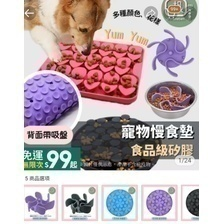

=== 測試結果 ===
    id             type answers predicted  is_correct
5    6       true_false    True     False           0
6    7       true_false    True     False           0
7    8       true_false    True      True           1
8    9       true_false    True     False           0
11  12       true_false   False     False           1
12  13       true_false   False     False           1
13  14       true_false   False     False           1
15  16       true_false    True     False           0
16  17       true_false    True     False           0
22  24  multiple_choice       C         C           1
23  25  multiple_choice       B         B           1
24  26  multiple_choice       B         B           1
25  27  multiple_choice       C         A           0
26  28  multiple_choice       B         B           1
27  29  multiple_choice       B         B           1
28  30  multiple_choice       B         B           1
29  31  multiple_choice       C         C           1
30  32  multipl

In [49]:
import string
import re
import pandas as pd
from deep_translator import GoogleTranslator

def translate_zh_to_en(chinese_text: str) -> str:
    try:
        # 指定原文語言為 'zh'（中文），目標語言為 'en'（英文）
        translator = GoogleTranslator(source='zh-TW', target='en')
        result = translator.translate(chinese_text)
        return result
    except Exception as e:
        print(f"翻譯錯誤：{e} - 對應中文問題：{chinese_text}")
        return chinese_text  # 若翻譯失敗，返回原文



def parse_llm_answer(llm_response: str, q_type: str) -> str:
    """
    根據題型 (選擇 or 是非)，從 LLM 的回覆字串中解析出可能的最終答案。
    """

    # 把回覆都轉小寫，以便搜尋
    q_type = q_type.strip().lower()        # 保險起見
    cleaned = llm_response.strip()
    
    
    if q_type == "multiple_choice":
       
        # 1) 先去除可能的全形/半形混雜、移除多餘符號等（可選）
        #    下面先做個最基本的 strip() 處理
        cleaned = llm_response.strip()

        # 2) 建立 Regex：
        #    - `^[ \t]*(A|B|C|D)[ \t]*$`：代表這一行(含前後空白)只有 A/B/C/D
        #    - (?m) 代表 MULTILINE 模式，使 ^ 和 $ 可以匹配每一行的開頭與結尾
        pattern = re.compile(r'^[ \t]*(A|B|C|D)[ \t]*$', re.MULTILINE)

        # 3) 搜尋
        match = pattern.search(cleaned)
        if match:
            # group(1) 會是 'A' or 'B' or 'C' or 'D'
            return match.group(1)
        else:
            return "UNKNOWN"
    
    elif q_type == "true_false":

        for line in reversed(llm_response.splitlines()):
            line = line.strip().lower()
            if line.startswith(("結論", "答案")):
                if "true" in line or "是" in line:
                    return "True"
                if "false" in line or "否" in line or "不" in line:
                    return "False"
                
        negative_phrases = [
            "不是", "否", "不對", "false", "no", "不可以",
            "不能", "不行", "never", "cannot"
        ]
        positive_phrases = [
            "是", "對", "true", "yes", "可以",
            "能", "行", "可以的", "沒問題"
        ]
       # 去掉標點
        text_nopunct = re.sub(f"[{re.escape(string.punctuation)}]", " ", cleaned)

        for phrase in negative_phrases:
            if phrase in text_nopunct:
                return "False"
        for phrase in positive_phrases:
            if phrase in text_nopunct:
                return "True"
        return "UNKNOWN"
    
    else:
        return "UNKNOWN"


def main():
    # 讀取題目資料
    df = pd.read_excel("test_questions.xlsx")
    
    # 篩選 type = multiple_choice 或 true_false 或 qa
    test_df = df[df["type"].isin(["multiple_choice","true_false"])].copy()
    # test_df = df[df["type"].isin(["true_false"])].copy()
    # test_df = test_df.head(4)
    
    # 新增欄位來存儲系統的回覆 & 預測答案
    test_df["llm_response"] = ""
    test_df["predicted"] = ""
    test_df["is_correct"] = 0
    
    for idx, row in test_df.iterrows():
        q = row["question"]
        en_q = translate_zh_to_en(q)
        q_type = row["type"]
        correct_ans = str(row["answers"]).strip()
        
        # llm_resp = qa_system.display_response(q)
        try:
            response_text, _ = qa_system.display_response(en_q,q_type)

        except Exception as e:
            print(f"Error with query {en_q}: {e}")
            response_text = "No response"
        
        # 解析出預測答案
        # pred_ans = parse_llm_answer(llm_resp, q_type)
        pred_ans = parse_llm_answer(response_text, q_type)
        
        # 比對正確答案
        # 為保險，正確答案也 upper 或 lower 下來比較
        is_correct = 1 if pred_ans.upper() == correct_ans.upper() else 0
        
        # 寫回 DataFrame
        test_df.at[idx, "llm_response"] = response_text
        test_df.at[idx, "predicted"] = pred_ans
        test_df.at[idx, "is_correct"] = is_correct
    
    # 計算 Accuracy
    total = len(test_df)
    correct_count = test_df["is_correct"].sum()
    accuracy = correct_count / total if total>0 else 0.0
    
    print("=== 測試結果 ===")
    print(test_df[["id","type","answers","predicted","is_correct"]])
    print(f"\n共 {total} 題，正確 {correct_count} 題，Accuracy = {accuracy:.2f}")
    
    # 若需要將回覆結果輸出 CSV 
    test_df.to_csv("test_result.csv", index=False, encoding='utf-8')
    print("結果已儲存 test_result.csv")

if __name__ == "__main__":
    main()
